# GAN : Generative Adversarial Network

## GAN

Let's briefly see how GAN works.

### Introduction

We implement the **generator** $P(X|z)$ as a NN. It takes in input a latent vector $z$ (i.e. random seed/noise) and it generates an image $\hat{X}$. We remind that the prior distribution $P(z)$ is known (gaussian $N(0,1))$: so, we know how to sample a latent encoding $z$.

We couple the generator with another NN: the **discriminator**. It's a classic classifier NN. It takes in input an instance (either real instance $X$ or generated by the generator $\hat{X}$) and it classifies it either as real or fake. It is a binary classifier NN. Labels $1/0$: $1$ for "real", $0$ for fake. The output of the discriminator is the probability of being real.

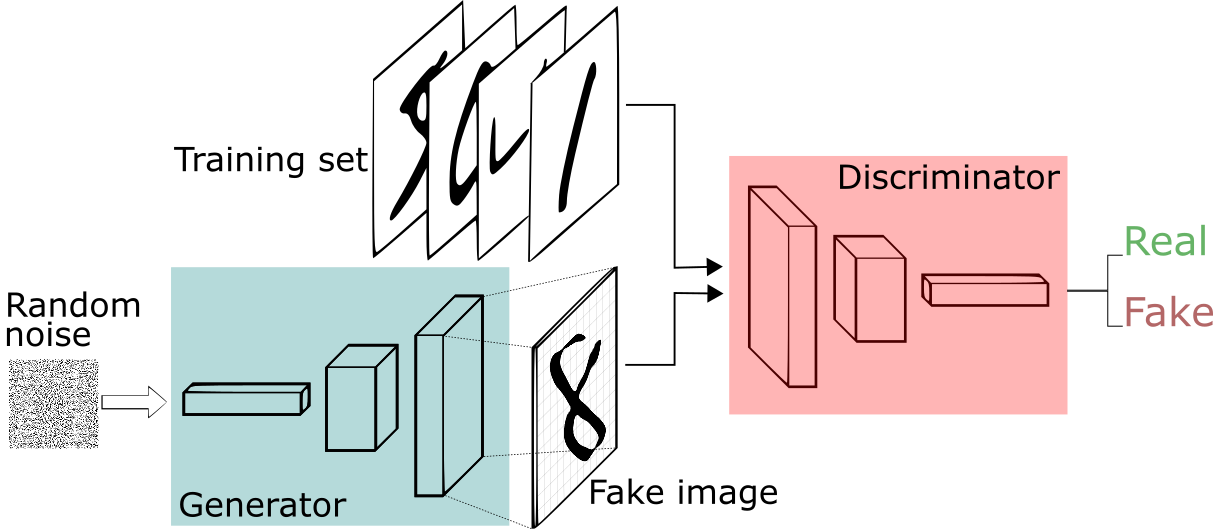

Intuitively, the training works in the following way. The two NNs are trained in an alterning way: when one is trained, the other is freezed.
1. The generator is freezed. The discriminator is trained.
2. The discriminator is freezed. The generator is trained.
3. The generator is freezed. The discriminator is trained.

...

The two NNS have dual and opposite objectives. The aim of the discriminator is to discriminate the generated images from the real ones, while the aim of the generator is to fool the discriminator. The training is like a Min-Max game: two opponents.

### Loss function

Loss $V(D,G)$: it depends on both the discriminator $D$ and the generator $G$.

The loss has two components: component which measures the goodness of the discriminator in detecting the real images and component which measures the goodness of the discriminator in detecting the fake images. 

**Goodness of the discriminator in detecting the real images**

Suppose we have a real image $X$. $D(X)$ is the output of the discriminator: probability of beign "real" (i.e. $1$).

We compute $log(D(X))$: the bigger it is, the better is the discriminator in detecting that $X$ is real.

Let $P_{data}$ the portion of the training set containing the real images. The mean $E_{X \in P_{data}}(logD(X))$ is the measure of the goodness of the discriminator in detecting the real images. Average of $log(D(X))$ across all real images $X$.

**Goodness of the discriminator in detecting fake images**

Suppose that we have a latent encoding $z$. We generate a fake image using the generator $\hat{X} = G(z)$. $D(G(z))$ is the output of the discriminator on that fake image: probability of being real. We consider $log(1-D(G(z)))$: the bigger is that value, and the better is the discriminator in detecting that this image is fake.

Let $P_z$ be the set of generated latent encodings $z$ for the training. The mean $E_{z \in P_z}(log(1-D(G(z))))$ is the measure of the goodnes of the generator in detecting the fake images. Average of $log(1-D(G(z)))$ across all the latent encodings $z$.

**Loss function**

The loss function is the sum of these two components. $V(D,G)=E_{X \in P_{data}}(logD(X)) + E_{z \in P_z}(log(1-D(G(z))))$

- The discriminator $D$ wants to maximize this loss
- The generator $G$ wants to minimize this loss. Actually, it does not want to minimize the full loss $V(D,G)$, but only $E_{z \in P_z}(log(1-D(G(z))))$, because $G$ does not impact the other component.

### Training

In an alterning way, we train and the generator, while the other NN is freezed.
- While we train the discriminator, the generator is freezed.
- While we train the generator, the discriminator is freezed.

Min-Max alterning game.

**Algorithm**

In each training step
1. Training step for the discriminator. We freeze the generator.
    - Take a batch of $m$ real images $X^{(i)}$.
    - Take a batch of $m$ latent encodings $z^{(i)}$. (Sampled from N(0,1)).
    - Compute the loss $1/m * \sum_{i=1}^m(logD(X^{(i)})) + log(1-D(G(z^{(i)}))))$
    - Update the weigths of the discriminator by performing gradient ascent (maximization), backpropagating this loss.
2. Training step for the generator. We freeze the discriminator.
    - Take a batch of $m$ latent encodings $z^{(i)}$. (Sampled from N(0,1)).
    - Compute the loss $\sum_{i=1}^m(log(1-D(G(z^{(i)}))))$
    - Update the weigths of the generator by performing gradient descent (minimization), backpropagating this loss.

## GAN MNIST DATASET

Let's implement the GAN model on the MNIST dataset. In particular, we use Conv layers: both the discriminator and the generator are Conv NNs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Normalization. This time we don't normalize into $[0,1]$, but into $[-1,1]$ (arbitrary choice).

In [3]:
x_train = (x_train - 127.5) / 127.5  # Normalize the values into [-1, 1]

Adding the channels dimension. Beacuse we use Conv NNs.

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

### Latent dimension

We fix the size of the random seed/latent encoding $z$ to $100$.

In [5]:
latent_dim = 100

### Generator

We define it as a Conv NN. It takes in input a latent encoding $z$ and it generates an images $X$.

So, it starts from a flat input of dimension $100$, and it generates a structured output of dimensions $28x28x1$.

For doing so, we follow this pattern.
1. Input $z$: dimension $100$.
2. Dense layer, producing $7*7*256=12544$ values.

Now, we want to increase the spatial dimensions. For doing so, we use Transposed Conv layers.

3. Reshaping from flat dimension $12544$ to dimensions $7, 7, 256$. 
3. Transposed Conv layer, with output dimensions $7, 7, 128$.
4. Transposed Conv layer, with output dimensions $14, 14, 64$.
5. Transposed Conv layer, with output dimensions $28, 28, 1$. The output is the generated image $\hat{X}$. THe activation function is **arctan**, beacuse we want to generate values in the range $[-1,1]$.

In addition, we use also the **leaky relu** activation function and the Batch normalization, in all the layers except the last one.

In [6]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras import Model

In [7]:
# Input: latent encoding z
zin = Input(shape=(latent_dim,))

# Dense layer
z = Dense(units=7*7*256, use_bias=False)(zin)
z = BatchNormalization()(z)
z = LeakyReLU()(z)

# Reshaping
z = Reshape((7,7,256))(z)

# Transposed Conv layer
z = Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False)(z)
z = BatchNormalization()(z)
z = LeakyReLU()(z)

# Transposed Conv layer
z = Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)(z)
z = BatchNormalization()(z)
z = LeakyReLU()(z)

# Last layer: transposed Conv layer. It returns the generated image x_hat
x_hat = Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, 
                        activation='tanh')(z)

generator = Model(inputs=zin, outputs=x_hat, name='Generator')

In [8]:
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                 

We may try to generate an image now. SInce the generator is not trained yet, it generates a completely randomic image.

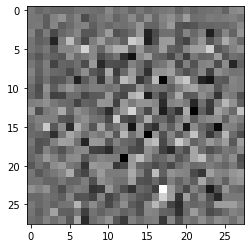

In [10]:
# Random seed z
latent_encoding = tf.random.normal([1, latent_dim])

# Generate an image
x_hat = generator(latent_encoding, training=False)

plt.imshow(x_hat[0, :, :, 0], cmap='gray')

### Discriminator

We define it as a Conv NN. It is a classic Conv NN for classification.
- Conv part: Conv layers. Gradual decreasing of the spatial dimensions, and increasing of the channels dimension.
- Flattening
- Dense part: Dense layer. Features exploitation. Only one dense layer, which is the output layer. It has one single output, which is the probability of being in the class $1$ (probability of being a real image). **sigmoid** activation function.

In addition, we use **leaky relu** activation function and DropOut in the Conv layers.

In [11]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten

In [12]:
### INPUT. Image x (either real or fake)
xin = Input(shape=(28, 28, 1))

### CONV PART
x = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same')(xin)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

x = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

out = Dense(units=1, activation='sigmoid')(x)

discriminator = Model(inputs=xin, outputs=out)

In [136]:
discriminator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 128)         0   

### Loss function

Let's define the loss function.

Actually, we define two loss functions: one for the discriminator, and one for the generator.

**Loss function for the discriminator**

This function takes in input two vectors.
- `real_images_predictions` Vector of the outputs of the discriminator on the batch of real images. For each real image in the given batch, this vector contains a value, which is the prediction made by the discriminator: it is the probability of being a real image.
- `fake_images_predictions` Vector of the outputs of the discriminator on the batch of fake images. For each fake image in the given batch, this vector contains a value, which is the prediction made by the discriminator: it is the probability of being a real image.

Given these two quantities, we want to compute the loss on the real images and the loss on the fake images. LEt $m$ be the number of real/fake images in a batch (Same number of fake and real images in a batch). 

We do this in a slightly different way with respect to what we have seen before.

- Loss on the real images. It can be computed as the binary crossentropy between a vector with length $m$ of all $1$ and the vector `real_images_predictions`. More precisely, we compute the binary crossentropy between each value in `real_images_predictions` and $1$, and then we compute the mean.
- Loss on the fake images. It can be computed as the binary crossentropy between a vector with length $m$ of all $0$ and the vector `fake_images_predictions`. More precisely, we compute the binary crossentropy between each value in `fake_images_predictions` and $0$, and then we compute the mean.

The actual loss of the discriminator is the sum between the loss on the real imaes and the loss on the fake images.

The aim of the discriminator is to minimize this loss (contrary from what we have seen before). The binary crossentropy is a distance measure.

In [13]:
from tensorflow.keras.losses import BinaryCrossentropy
binary_crossentropy = BinaryCrossentropy()

In [14]:
def discriminator_loss_function(real_images_predictions, fake_images_predictions):
    # Loss on the real images
    vector_all_ones = tf.ones_like(real_images_predictions)
    real_images_loss = binary_crossentropy(vector_all_ones, real_images_predictions)
    
    # Loss on the fake images
    vector_all_zeros = tf.zeros_like(fake_images_predictions)
    fake_images_loss = binary_crossentropy(vector_all_zeros, fake_images_predictions)
    
    # Whole loss
    total_loss = real_images_loss + fake_images_loss
    
    return total_loss

**Loss function for the generator**

This function takes in input only the `fake_images_predictions` (i.e. vector of the outputs of the discriminator on the batch of fake images). 

Given these two quantities, we want to compute the loss on the fake images. Only the loss on the fake images. 

We compute the loss on the fake images as the binary crossentropy between a vector with length $m$ of all $1$ and the vector `fake_images_predictions`. More precisely, we compute the binary crossentropy between each value in `fake_images_predictions` and $1$, and then we compute the mean.

We take values $1$ and not $0$ beacuse in this way the aim of the generator is to minimize this loss. It is an error measure of the generator.

In [15]:
def generator_loss_function(fake_images_predictions):
    vector_all_ones = tf.ones_like(fake_images_predictions)
    fake_images_loss = binary_crossentropy(vector_all_ones, fake_images_predictions)
    return fake_images_loss

### Training

Finally, let's implement the training procedure.

In [ ]:
### LOADING THE WEIGTHS
#generator.load_weights('generator.h5')
#discriminator.load_weights('discriminator.h5')

**Optimizers**

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**Training step**

Function which performs a training step, both for the discriminator and the generator.

It takes in input a batch of real images $X$.

In [17]:
# Notice the use of `tf.function`: this annotation causes the function to be "compiled".
@tf.function
def train_step(batch_real_images):
    # Batch of latent encodings z
    batch_latent_encodings = tf.random.normal([BATCH_SIZE, latent_dim])

    # Computing the discriminator and the generator losses
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
      # Generating the batch of fake images, given the batch of latent encodings
      batch_generated_images = generator(batch_latent_encodings, training=True)

      # Predictions of the discriminator on the real images
      real_images_predictions = discriminator(batch_real_images, training=True)
      # Predictions of the discriminator on the fake images
      fake_images_predictions = discriminator(batch_generated_images, training=True)
    
      # Loss of the generator
      generator_loss = generator_loss_function(fake_images_predictions)
      # Loss of the discriminator
      discriminator_loss = discriminator_loss_function(real_images_predictions, fake_images_predictions)

    # Computing the gradients of the generator loss, with respect to all the weigths of the generator
    gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
    # Computing the gradients of the discriminator loss, with respect to all the weigths of the discriminator
    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    # Apply the backpropagation of the gradients on the weigths. Update of the weigths. On both NNs
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # Return the losses of the generator and of the discriminator on this current batch
    return generator_loss, discriminator_loss

**Training**

Now that we have defined the training step function, we can perform the training.

In [21]:
import time

Defining the number of epochs and the batch size.

In [18]:
EPOCHS = 50
BATCH_SIZE = 256

Dividing the training set into batches. Basically, the returned object is an iterable structure, which is iterable over the batches.

In [19]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)

Training procedure. WARNING: Almost $7$ hours of training (wuthout GPU).

In [144]:
# Flag telling if it has been done the first batch
first_batch_done = False

# Generator and discriminator losses, computed incrementally over the batches
generator_loss, discriminator_loss = None, None

# Iterating over all the epochs
for epoch in range(EPOCHS):
    # EPOCH
    
    start = time.time()

    # Iterating over all the batches in that epoch
    for batch_real_images in x_train:
      # TRAINING STEP  
        
      # Generator and discriminator losses in that batch 
      generator_loss_batch, discriminator_loss_batch = train_step(batch_real_images)
        
      # Updating the actual generator and discriminator losses
      if not first_batch_done:
        generator_loss, discriminator_loss = generator_loss_batch, discriminator_loss_batch
      else:
        generator_loss = 1/2 * (generator_loss + generator_loss_batch)
        discriminator_loss = 1/2 * (discriminator_loss + discriminator_loss_batch)
      
      first_batch_done = True
        
      # End training step
      print(f'\tGenerator loss: {generator_loss}, Discriminator loss: {discriminator_loss}')
    
    # End epoch
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

	Generator loss: 0.677014946937561, Discriminator loss: 1.3491767644882202
	Generator loss: 0.6640063524246216, Discriminator loss: 1.3335912227630615
	Generator loss: 0.6468921899795532, Discriminator loss: 1.314003825187683
	Generator loss: 0.6265604496002197, Discriminator loss: 1.2930049896240234
	Generator loss: 0.6088463664054871, Discriminator loss: 1.2671630382537842
	Generator loss: 0.5898944139480591, Discriminator loss: 1.249624252319336
	Generator loss: 0.5759036540985107, Discriminator loss: 1.2245311737060547
	Generator loss: 0.5651317834854126, Discriminator loss: 1.2006793022155762
	Generator loss: 0.5563564300537109, Discriminator loss: 1.18065345287323
	Generator loss: 0.5480780601501465, Discriminator loss: 1.1635420322418213
	Generator loss: 0.5419126749038696, Discriminator loss: 1.1451250314712524
	Generator loss: 0.5381556153297424, Discriminator loss: 1.1261706352233887
	Generator loss: 0.5339550971984863, Discriminator loss: 1.1082963943481445
	Generator loss: 

	Generator loss: 0.8356623649597168, Discriminator loss: 0.8873085975646973
	Generator loss: 0.8268160223960876, Discriminator loss: 0.8807362914085388
	Generator loss: 0.8104394674301147, Discriminator loss: 0.8834721446037292
	Generator loss: 0.7932038903236389, Discriminator loss: 0.8859573602676392
	Generator loss: 0.7600727081298828, Discriminator loss: 0.9150193929672241
	Generator loss: 0.7217538356781006, Discriminator loss: 0.9491752982139587
	Generator loss: 0.6859130859375, Discriminator loss: 0.9815077781677246
	Generator loss: 0.64190274477005, Discriminator loss: 1.0373821258544922
	Generator loss: 0.5947540998458862, Discriminator loss: 1.1163198947906494
	Generator loss: 0.5588991641998291, Discriminator loss: 1.1707277297973633
	Generator loss: 0.554194986820221, Discriminator loss: 1.1863200664520264
	Generator loss: 0.5774621963500977, Discriminator loss: 1.1645102500915527
	Generator loss: 0.6195647120475769, Discriminator loss: 1.1485581398010254
	Generator loss: 0

	Generator loss: 1.0135056972503662, Discriminator loss: 0.9311379194259644
	Generator loss: 1.048398494720459, Discriminator loss: 0.9036275148391724
	Generator loss: 1.073205828666687, Discriminator loss: 0.8679684996604919
	Generator loss: 1.1067806482315063, Discriminator loss: 0.8742936849594116
	Generator loss: 1.1202383041381836, Discriminator loss: 0.8321177959442139
	Generator loss: 1.1375101804733276, Discriminator loss: 0.8158541917800903
	Generator loss: 1.1445298194885254, Discriminator loss: 0.8198376893997192
	Generator loss: 1.1581015586853027, Discriminator loss: 0.7929383516311646
	Generator loss: 1.1718456745147705, Discriminator loss: 0.812767744064331
	Generator loss: 1.1871968507766724, Discriminator loss: 0.8246344923973083
	Generator loss: 1.197548270225525, Discriminator loss: 0.8312159776687622
	Generator loss: 1.2084250450134277, Discriminator loss: 0.80975341796875
	Generator loss: 1.2229561805725098, Discriminator loss: 0.823052704334259
	Generator loss: 1.

	Generator loss: 0.6016803979873657, Discriminator loss: 1.810575246810913
	Generator loss: 0.6043212413787842, Discriminator loss: 1.7193875312805176
	Generator loss: 0.6223354935646057, Discriminator loss: 1.6757571697235107
	Generator loss: 0.6422561407089233, Discriminator loss: 1.6433918476104736
	Generator loss: 0.663886547088623, Discriminator loss: 1.6537152528762817
	Generator loss: 0.688138484954834, Discriminator loss: 1.6713504791259766
	Generator loss: 0.6828300952911377, Discriminator loss: 1.6065186262130737
	Generator loss: 0.6726703643798828, Discriminator loss: 1.6144039630889893
	Generator loss: 0.6591351628303528, Discriminator loss: 1.6221981048583984
	Generator loss: 0.6533228158950806, Discriminator loss: 1.5577694177627563
	Generator loss: 0.6654956340789795, Discriminator loss: 1.5308432579040527
	Generator loss: 0.6708642840385437, Discriminator loss: 1.504365086555481
	Generator loss: 0.6925392150878906, Discriminator loss: 1.479421854019165
	Generator loss: 

	Generator loss: 0.942896842956543, Discriminator loss: 1.055619239807129
	Generator loss: 0.9387094378471375, Discriminator loss: 1.056734323501587
	Generator loss: 0.9057839512825012, Discriminator loss: 1.0676087141036987
	Generator loss: 0.8934520483016968, Discriminator loss: 1.084644079208374
	Generator loss: 0.8974895477294922, Discriminator loss: 1.1133596897125244
	Generator loss: 0.9105442762374878, Discriminator loss: 1.1183615922927856
	Generator loss: 0.8957905769348145, Discriminator loss: 1.1656854152679443
	Generator loss: 0.8851075172424316, Discriminator loss: 1.202043890953064
	Generator loss: 0.8886441588401794, Discriminator loss: 1.2060766220092773
	Generator loss: 0.896240234375, Discriminator loss: 1.2186610698699951
	Generator loss: 0.8795801401138306, Discriminator loss: 1.2105273008346558
	Generator loss: 0.8777086138725281, Discriminator loss: 1.2588413953781128
	Generator loss: 0.827521562576294, Discriminator loss: 1.369821548461914
	Generator loss: 0.8175

	Generator loss: 0.6622704267501831, Discriminator loss: 1.490743637084961
	Generator loss: 0.6809537410736084, Discriminator loss: 1.4948177337646484
	Generator loss: 0.6846166849136353, Discriminator loss: 1.5002155303955078
	Generator loss: 0.7018546462059021, Discriminator loss: 1.4743050336837769
	Generator loss: 0.70699143409729, Discriminator loss: 1.5161702632904053
	Generator loss: 0.7241873145103455, Discriminator loss: 1.5471094846725464
	Generator loss: 0.716523289680481, Discriminator loss: 1.5036842823028564
	Generator loss: 0.6991778612136841, Discriminator loss: 1.4886986017227173
	Generator loss: 0.6789780855178833, Discriminator loss: 1.5186527967453003
	Generator loss: 0.6640815734863281, Discriminator loss: 1.502873420715332
	Generator loss: 0.6584054231643677, Discriminator loss: 1.482750415802002
	Generator loss: 0.6551603078842163, Discriminator loss: 1.469228982925415
	Generator loss: 0.6631933450698853, Discriminator loss: 1.465010643005371
	Generator loss: 0.6

	Generator loss: 0.877434492111206, Discriminator loss: 1.1989812850952148
	Generator loss: 0.8930690288543701, Discriminator loss: 1.184753656387329
	Generator loss: 0.9029707312583923, Discriminator loss: 1.2026995420455933
	Generator loss: 0.9171042442321777, Discriminator loss: 1.2014963626861572
	Generator loss: 0.9232112169265747, Discriminator loss: 1.1795005798339844
	Generator loss: 0.9116063714027405, Discriminator loss: 1.1635938882827759
	Generator loss: 0.9044092297554016, Discriminator loss: 1.1598033905029297
	Generator loss: 0.9095369577407837, Discriminator loss: 1.1568242311477661
	Generator loss: 0.9154852032661438, Discriminator loss: 1.146012544631958
	Generator loss: 0.9221941232681274, Discriminator loss: 1.1950175762176514
	Generator loss: 0.8948005437850952, Discriminator loss: 1.1883653402328491
	Generator loss: 0.8735350370407104, Discriminator loss: 1.198608636856079
	Generator loss: 0.8570879697799683, Discriminator loss: 1.2103402614593506
	Generator loss:

	Generator loss: 0.7547041177749634, Discriminator loss: 1.377813696861267
	Generator loss: 0.7621762156486511, Discriminator loss: 1.3311200141906738
	Generator loss: 0.7982672452926636, Discriminator loss: 1.3383045196533203
	Generator loss: 0.825653076171875, Discriminator loss: 1.2722046375274658
	Generator loss: 0.8571401238441467, Discriminator loss: 1.2256191968917847
	Generator loss: 0.8910418748855591, Discriminator loss: 1.197685956954956
	Generator loss: 0.9071065783500671, Discriminator loss: 1.174328327178955
	Generator loss: 0.926025390625, Discriminator loss: 1.1518661975860596
	Generator loss: 0.9438762664794922, Discriminator loss: 1.1069879531860352
	Generator loss: 0.9491037130355835, Discriminator loss: 1.0752923488616943
	Generator loss: 0.9560716152191162, Discriminator loss: 1.082604169845581
	Generator loss: 0.9921523332595825, Discriminator loss: 1.0696650743484497
	Generator loss: 1.0227422714233398, Discriminator loss: 1.060502290725708
	Generator loss: 1.029

	Generator loss: 0.9969120025634766, Discriminator loss: 0.946040153503418
	Generator loss: 1.029171347618103, Discriminator loss: 0.9423625469207764
	Generator loss: 1.079850673675537, Discriminator loss: 0.9554774761199951
	Generator loss: 1.1176707744598389, Discriminator loss: 0.9443415403366089
	Generator loss: 1.108144760131836, Discriminator loss: 0.9338454604148865
	Generator loss: 1.0864282846450806, Discriminator loss: 0.940626859664917
	Generator loss: 1.0618326663970947, Discriminator loss: 0.9343342185020447
	Generator loss: 1.043615698814392, Discriminator loss: 0.9499454498291016
	Generator loss: 1.0558147430419922, Discriminator loss: 0.9824125170707703
	Generator loss: 1.063225507736206, Discriminator loss: 0.9783670902252197
	Generator loss: 1.0484004020690918, Discriminator loss: 0.9731554985046387
	Generator loss: 1.0459203720092773, Discriminator loss: 0.9941914081573486
	Generator loss: 1.0015395879745483, Discriminator loss: 1.0216000080108643
	Generator loss: 1.

	Generator loss: 1.0707097053527832, Discriminator loss: 1.002000093460083
	Generator loss: 1.0696412324905396, Discriminator loss: 0.9931507706642151
	Generator loss: 1.0794239044189453, Discriminator loss: 0.9901703596115112
	Generator loss: 1.0778459310531616, Discriminator loss: 1.0069301128387451
	Generator loss: 1.0949726104736328, Discriminator loss: 1.0055160522460938
	Generator loss: 1.0895044803619385, Discriminator loss: 1.0288126468658447
	Generator loss: 1.0577629804611206, Discriminator loss: 1.0284514427185059
	Generator loss: 1.0391201972961426, Discriminator loss: 1.0543498992919922
	Generator loss: 1.0304404497146606, Discriminator loss: 1.0409774780273438
	Generator loss: 1.0008764266967773, Discriminator loss: 1.0549261569976807
	Generator loss: 0.999146580696106, Discriminator loss: 1.0616767406463623
	Generator loss: 1.0255441665649414, Discriminator loss: 1.059326171875
	Generator loss: 1.0517762899398804, Discriminator loss: 1.096429705619812
	Generator loss: 1.

	Generator loss: 0.9158260226249695, Discriminator loss: 1.392625331878662
	Generator loss: 0.9180769920349121, Discriminator loss: 1.319166660308838
	Generator loss: 0.922029972076416, Discriminator loss: 1.2435541152954102
	Generator loss: 0.9652502536773682, Discriminator loss: 1.195763349533081
	Generator loss: 1.0063300132751465, Discriminator loss: 1.1666481494903564
	Generator loss: 1.0663279294967651, Discriminator loss: 1.0650172233581543
	Generator loss: 1.0856094360351562, Discriminator loss: 1.047997236251831
	Generator loss: 1.1149415969848633, Discriminator loss: 1.047324538230896
	Generator loss: 1.1431366205215454, Discriminator loss: 1.022352933883667
	Generator loss: 1.1278445720672607, Discriminator loss: 1.017566442489624
	Generator loss: 1.1120924949645996, Discriminator loss: 0.9563238620758057
	Generator loss: 1.0972461700439453, Discriminator loss: 0.9343971014022827
	Generator loss: 1.1455718278884888, Discriminator loss: 0.9343708753585815
	Generator loss: 1.1

	Generator loss: 0.8118747472763062, Discriminator loss: 1.4572370052337646
	Generator loss: 0.7819026112556458, Discriminator loss: 1.499894380569458
	Generator loss: 0.777733325958252, Discriminator loss: 1.5597336292266846
	Generator loss: 0.7714951038360596, Discriminator loss: 1.5245254039764404
	Generator loss: 0.7973625659942627, Discriminator loss: 1.7509465217590332
	Generator loss: 0.8009719848632812, Discriminator loss: 1.8142900466918945
	Generator loss: 0.7943308353424072, Discriminator loss: 1.6470452547073364
	Generator loss: 0.7616103291511536, Discriminator loss: 1.5539851188659668
	Generator loss: 0.7266122102737427, Discriminator loss: 1.5621695518493652
	Generator loss: 0.7346344590187073, Discriminator loss: 1.492301106452942
	Generator loss: 0.7620963454246521, Discriminator loss: 1.4873199462890625
	Generator loss: 0.804162859916687, Discriminator loss: 1.5775115489959717
	Generator loss: 0.8103228807449341, Discriminator loss: 1.6614861488342285
	Generator loss:

	Generator loss: 0.754352331161499, Discriminator loss: 1.3984335660934448
	Generator loss: 0.7709906697273254, Discriminator loss: 1.3769276142120361
	Generator loss: 0.7675744295120239, Discriminator loss: 1.4022842645645142
	Generator loss: 0.7651084065437317, Discriminator loss: 1.3858855962753296
	Generator loss: 0.7681403160095215, Discriminator loss: 1.3522828817367554
	Generator loss: 0.7546730637550354, Discriminator loss: 1.3382093906402588
	Generator loss: 0.7712211608886719, Discriminator loss: 1.3122639656066895
	Generator loss: 0.7864055037498474, Discriminator loss: 1.3121634721755981
	Generator loss: 0.8135713338851929, Discriminator loss: 1.3001058101654053
	Generator loss: 0.8281370997428894, Discriminator loss: 1.2833071947097778
	Generator loss: 0.8576874732971191, Discriminator loss: 1.2866735458374023
	Generator loss: 0.8599191308021545, Discriminator loss: 1.2424513101577759
	Generator loss: 0.8322125673294067, Discriminator loss: 1.2479785680770874
	Generator lo

	Generator loss: 0.9140382409095764, Discriminator loss: 1.2338085174560547
	Generator loss: 0.8549801111221313, Discriminator loss: 1.2361793518066406
	Generator loss: 0.8047940731048584, Discriminator loss: 1.2314385175704956
	Generator loss: 0.7765827178955078, Discriminator loss: 1.2371093034744263
	Generator loss: 0.7793700098991394, Discriminator loss: 1.2172253131866455
	Generator loss: 0.8162798881530762, Discriminator loss: 1.2245937585830688
	Generator loss: 0.8602534532546997, Discriminator loss: 1.2078135013580322
	Generator loss: 0.9111059904098511, Discriminator loss: 1.1812615394592285
	Generator loss: 0.9353583455085754, Discriminator loss: 1.2321016788482666
	Generator loss: 0.9489254951477051, Discriminator loss: 1.2368216514587402
	Generator loss: 0.916584312915802, Discriminator loss: 1.2590279579162598
	Generator loss: 0.8704097270965576, Discriminator loss: 1.2890125513076782
	Generator loss: 0.810163140296936, Discriminator loss: 1.2942917346954346
	Generator los

	Generator loss: 0.8040077686309814, Discriminator loss: 1.3454821109771729
	Generator loss: 0.8230663537979126, Discriminator loss: 1.3273801803588867
	Generator loss: 0.8392254114151001, Discriminator loss: 1.2927494049072266
	Generator loss: 0.8492395877838135, Discriminator loss: 1.2881708145141602
	Generator loss: 0.8700364232063293, Discriminator loss: 1.2994132041931152
	Generator loss: 0.8914663195610046, Discriminator loss: 1.2523280382156372
	Generator loss: 0.9075417518615723, Discriminator loss: 1.228266954421997
	Generator loss: 0.90137779712677, Discriminator loss: 1.2408525943756104
	Generator loss: 0.8749467134475708, Discriminator loss: 1.2032415866851807
	Generator loss: 0.8668309450149536, Discriminator loss: 1.1878817081451416
	Generator loss: 0.8553748726844788, Discriminator loss: 1.1834408044815063
	Generator loss: 0.8642048239707947, Discriminator loss: 1.1814565658569336
	Generator loss: 0.8869638442993164, Discriminator loss: 1.1858210563659668
	Generator loss

	Generator loss: 0.8653624057769775, Discriminator loss: 1.2515921592712402
	Generator loss: 0.8673442006111145, Discriminator loss: 1.2323851585388184
	Generator loss: 0.8800280094146729, Discriminator loss: 1.2319315671920776
	Generator loss: 0.9003196358680725, Discriminator loss: 1.1993868350982666
	Generator loss: 0.9066655039787292, Discriminator loss: 1.223349928855896
	Generator loss: 0.9179619550704956, Discriminator loss: 1.2357274293899536
	Generator loss: 0.8943773508071899, Discriminator loss: 1.2033884525299072
	Generator loss: 0.885482907295227, Discriminator loss: 1.1775058507919312
	Generator loss: 0.8809019327163696, Discriminator loss: 1.197385311126709
	Generator loss: 0.8725976943969727, Discriminator loss: 1.1745994091033936
	Generator loss: 0.867359459400177, Discriminator loss: 1.148427963256836
	Generator loss: 0.8891268968582153, Discriminator loss: 1.175220012664795
	Generator loss: 0.900825023651123, Discriminator loss: 1.2574557065963745
	Generator loss: 0.

	Generator loss: 0.72389155626297, Discriminator loss: 1.539768934249878
	Generator loss: 0.7026088833808899, Discriminator loss: 1.521295428276062
	Generator loss: 0.6874236464500427, Discriminator loss: 1.4829277992248535
	Generator loss: 0.6684894561767578, Discriminator loss: 1.4614354372024536
	Generator loss: 0.6451018452644348, Discriminator loss: 1.4498382806777954
	Generator loss: 0.6248617172241211, Discriminator loss: 1.459573745727539
	Generator loss: 0.628948986530304, Discriminator loss: 1.4121623039245605
	Generator loss: 0.6635867953300476, Discriminator loss: 1.344988465309143
	Generator loss: 0.6975324749946594, Discriminator loss: 1.3373758792877197
	Generator loss: 0.7466565370559692, Discriminator loss: 1.3153492212295532
	Generator loss: 0.7705954313278198, Discriminator loss: 1.2757089138031006
	Generator loss: 0.7900683283805847, Discriminator loss: 1.26619291305542
	Generator loss: 0.8163151741027832, Discriminator loss: 1.2217899560928345
	Generator loss: 0.82

	Generator loss: 0.906159520149231, Discriminator loss: 1.122969150543213
	Generator loss: 0.9021798968315125, Discriminator loss: 1.1637599468231201
	Generator loss: 0.9102804660797119, Discriminator loss: 1.1968210935592651
	Generator loss: 0.8967474699020386, Discriminator loss: 1.1921323537826538
	Generator loss: 0.87447589635849, Discriminator loss: 1.1880440711975098
	Generator loss: 0.8572087287902832, Discriminator loss: 1.2021808624267578
	Generator loss: 0.8430820107460022, Discriminator loss: 1.201775312423706
	Generator loss: 0.8346492052078247, Discriminator loss: 1.209221601486206
	Generator loss: 0.8387852311134338, Discriminator loss: 1.2346010208129883
	Generator loss: 0.8513097167015076, Discriminator loss: 1.2410768270492554
	Generator loss: 0.8475847244262695, Discriminator loss: 1.2784016132354736
	Generator loss: 0.8463354706764221, Discriminator loss: 1.2728970050811768
	Generator loss: 0.8356528878211975, Discriminator loss: 1.2764830589294434
	Generator loss: 0

	Generator loss: 0.8676144480705261, Discriminator loss: 1.2569063901901245
	Generator loss: 0.8783162832260132, Discriminator loss: 1.2738263607025146
	Generator loss: 0.8705034852027893, Discriminator loss: 1.2486953735351562
	Generator loss: 0.8590814471244812, Discriminator loss: 1.2596077919006348
	Generator loss: 0.8457789421081543, Discriminator loss: 1.2996013164520264
	Generator loss: 0.8262256383895874, Discriminator loss: 1.3273476362228394
	Generator loss: 0.8087654709815979, Discriminator loss: 1.3087129592895508
	Generator loss: 0.8058909177780151, Discriminator loss: 1.3229243755340576
	Generator loss: 0.8047347068786621, Discriminator loss: 1.339302897453308
	Generator loss: 0.8064897060394287, Discriminator loss: 1.34969162940979
	Generator loss: 0.7927385568618774, Discriminator loss: 1.361842393875122
	Generator loss: 0.7754727602005005, Discriminator loss: 1.3410590887069702
	Generator loss: 0.7585559487342834, Discriminator loss: 1.3865221738815308
	Generator loss:

	Generator loss: 0.9129897952079773, Discriminator loss: 1.1489176750183105
	Generator loss: 0.9217965602874756, Discriminator loss: 1.159055233001709
	Generator loss: 0.9282954931259155, Discriminator loss: 1.1911392211914062
	Generator loss: 0.9220679998397827, Discriminator loss: 1.1849063634872437
	Generator loss: 0.9203366637229919, Discriminator loss: 1.1844091415405273
	Generator loss: 0.9490193724632263, Discriminator loss: 1.1907048225402832
	Generator loss: 0.9394166469573975, Discriminator loss: 1.1995753049850464
	Generator loss: 0.94858717918396, Discriminator loss: 1.2002499103546143
	Generator loss: 0.9310312867164612, Discriminator loss: 1.2584880590438843
	Generator loss: 0.8983174562454224, Discriminator loss: 1.2742857933044434
	Generator loss: 0.8639998435974121, Discriminator loss: 1.2909126281738281
	Generator loss: 0.8268740177154541, Discriminator loss: 1.270039439201355
	Generator loss: 0.8163841366767883, Discriminator loss: 1.2650647163391113
	Generator loss:

	Generator loss: 0.9549434185028076, Discriminator loss: 1.171032428741455
	Generator loss: 0.9364749193191528, Discriminator loss: 1.1729638576507568
	Generator loss: 0.8978453278541565, Discriminator loss: 1.178868055343628
	Generator loss: 0.890349268913269, Discriminator loss: 1.1544018983840942
	Generator loss: 0.8980491757392883, Discriminator loss: 1.1423611640930176
	Generator loss: 0.9548701047897339, Discriminator loss: 1.1236220598220825
	Generator loss: 0.9724345803260803, Discriminator loss: 1.1604893207550049
	Generator loss: 0.9901049137115479, Discriminator loss: 1.1507647037506104
	Generator loss: 0.9639198780059814, Discriminator loss: 1.1480915546417236
	Generator loss: 0.9326220750808716, Discriminator loss: 1.1715809106826782
	Generator loss: 0.9072001576423645, Discriminator loss: 1.190438985824585
	Generator loss: 0.8713319301605225, Discriminator loss: 1.1660243272781372
	Generator loss: 0.8751628398895264, Discriminator loss: 1.186306118965149
	Generator loss: 

	Generator loss: 0.8964946269989014, Discriminator loss: 1.2107021808624268
	Generator loss: 0.8916354775428772, Discriminator loss: 1.230694055557251
	Generator loss: 0.8924233913421631, Discriminator loss: 1.2009259462356567
	Generator loss: 0.894657552242279, Discriminator loss: 1.1689672470092773
	Generator loss: 0.9052095413208008, Discriminator loss: 1.1518515348434448
	Generator loss: 0.9156458377838135, Discriminator loss: 1.1503713130950928
	Generator loss: 0.9281065464019775, Discriminator loss: 1.1395875215530396
	Generator loss: 0.9266172647476196, Discriminator loss: 1.1371996402740479
	Generator loss: 0.9366685152053833, Discriminator loss: 1.1403872966766357
	Generator loss: 0.9382916688919067, Discriminator loss: 1.1333739757537842
	Generator loss: 0.9345287680625916, Discriminator loss: 1.1492100954055786
	Generator loss: 0.936711311340332, Discriminator loss: 1.1547114849090576
	Generator loss: 0.9230527281761169, Discriminator loss: 1.1525830030441284
	Generator loss

	Generator loss: 0.8220793008804321, Discriminator loss: 1.320894479751587
	Generator loss: 0.849591076374054, Discriminator loss: 1.3514842987060547
	Generator loss: 0.8622727394104004, Discriminator loss: 1.4299280643463135
	Generator loss: 0.850556492805481, Discriminator loss: 1.3818714618682861
	Generator loss: 0.8384478092193604, Discriminator loss: 1.3698185682296753
	Generator loss: 0.818827748298645, Discriminator loss: 1.3423871994018555
	Generator loss: 0.8006455302238464, Discriminator loss: 1.3090198040008545
	Generator loss: 0.7878315448760986, Discriminator loss: 1.281208872795105
	Generator loss: 0.8047963976860046, Discriminator loss: 1.2705698013305664
	Generator loss: 0.832579493522644, Discriminator loss: 1.287712812423706
	Generator loss: 0.8719552755355835, Discriminator loss: 1.2612693309783936
	Generator loss: 0.8951555490493774, Discriminator loss: 1.2362520694732666
	Generator loss: 0.919838547706604, Discriminator loss: 1.2524234056472778
	Generator loss: 0.9

	Generator loss: 0.7965567111968994, Discriminator loss: 1.387878179550171
	Generator loss: 0.7954652905464172, Discriminator loss: 1.3601934909820557
	Generator loss: 0.7829986810684204, Discriminator loss: 1.3586770296096802
	Generator loss: 0.760439395904541, Discriminator loss: 1.3322036266326904
	Generator loss: 0.7577024698257446, Discriminator loss: 1.3132423162460327
	Generator loss: 0.7581074833869934, Discriminator loss: 1.3040568828582764
	Generator loss: 0.7845916748046875, Discriminator loss: 1.31977117061615
	Generator loss: 0.8137033581733704, Discriminator loss: 1.313279628753662
	Generator loss: 0.8236311674118042, Discriminator loss: 1.2775931358337402
	Generator loss: 0.8239811062812805, Discriminator loss: 1.2846786975860596
	Generator loss: 0.8326379060745239, Discriminator loss: 1.2524832487106323
	Generator loss: 0.8644267320632935, Discriminator loss: 1.2549781799316406
	Generator loss: 0.8730207681655884, Discriminator loss: 1.2008649110794067
	Generator loss: 

	Generator loss: 1.0150750875473022, Discriminator loss: 1.1754822731018066
	Generator loss: 0.9927456974983215, Discriminator loss: 1.1879538297653198
	Generator loss: 0.9836533069610596, Discriminator loss: 1.2635197639465332
	Generator loss: 0.9354265928268433, Discriminator loss: 1.2549735307693481
	Generator loss: 0.9171154499053955, Discriminator loss: 1.2544777393341064
	Generator loss: 0.9144794344902039, Discriminator loss: 1.313220500946045
	Generator loss: 0.9031832218170166, Discriminator loss: 1.499903917312622
	Generator loss: 0.81777024269104, Discriminator loss: 1.50007164478302
	Generator loss: 0.7156343460083008, Discriminator loss: 1.68873929977417
	Generator loss: 0.6275153756141663, Discriminator loss: 1.642732858657837
	Generator loss: 0.5870851278305054, Discriminator loss: 1.5914493799209595
	Generator loss: 0.5951526165008545, Discriminator loss: 1.5660929679870605
	Generator loss: 0.6891221404075623, Discriminator loss: 1.5636274814605713
	Generator loss: 0.79

	Generator loss: 0.9753454923629761, Discriminator loss: 1.1994740962982178
	Generator loss: 0.9932922720909119, Discriminator loss: 1.2108311653137207
	Generator loss: 1.002764105796814, Discriminator loss: 1.2446867227554321
	Generator loss: 0.9772118330001831, Discriminator loss: 1.2553434371948242
	Generator loss: 0.9414644241333008, Discriminator loss: 1.2580739259719849
	Generator loss: 0.8952119946479797, Discriminator loss: 1.2308802604675293
	Generator loss: 0.8682364225387573, Discriminator loss: 1.2533702850341797
	Generator loss: 0.8857778310775757, Discriminator loss: 1.2692749500274658
	Generator loss: 0.8943547606468201, Discriminator loss: 1.3439667224884033
	Generator loss: 0.9005395174026489, Discriminator loss: 1.33375084400177
	Generator loss: 0.904474139213562, Discriminator loss: 1.3071606159210205
	Generator loss: 0.889045774936676, Discriminator loss: 1.4203699827194214
	Generator loss: 0.84792160987854, Discriminator loss: 1.3242855072021484
	Generator loss: 0.

	Generator loss: 0.8385183215141296, Discriminator loss: 1.2342251539230347
	Generator loss: 0.8924382925033569, Discriminator loss: 1.2091410160064697
	Generator loss: 0.9440481066703796, Discriminator loss: 1.2443872690200806
	Generator loss: 0.9873712062835693, Discriminator loss: 1.2197740077972412
	Generator loss: 0.9896985292434692, Discriminator loss: 1.1867294311523438
	Generator loss: 0.988008975982666, Discriminator loss: 1.1725906133651733
	Generator loss: 0.9534133672714233, Discriminator loss: 1.1359541416168213
	Generator loss: 0.9449670314788818, Discriminator loss: 1.146583080291748
	Generator loss: 0.9603672027587891, Discriminator loss: 1.1188843250274658
	Generator loss: 0.9927060604095459, Discriminator loss: 1.1014496088027954
	Generator loss: 1.0180730819702148, Discriminator loss: 1.097277045249939
	Generator loss: 1.0365549325942993, Discriminator loss: 1.075824499130249
	Generator loss: 1.0021488666534424, Discriminator loss: 1.1002824306488037
	Generator loss:

	Generator loss: 0.9074985980987549, Discriminator loss: 1.2410366535186768
	Generator loss: 0.9210914373397827, Discriminator loss: 1.2374517917633057
	Generator loss: 0.9450584650039673, Discriminator loss: 1.2211248874664307
	Generator loss: 0.9352706670761108, Discriminator loss: 1.2429819107055664
	Generator loss: 0.9313020706176758, Discriminator loss: 1.2326834201812744
	Generator loss: 0.9363552927970886, Discriminator loss: 1.188978672027588
	Generator loss: 0.9153138399124146, Discriminator loss: 1.1800867319107056
	Generator loss: 0.9032595157623291, Discriminator loss: 1.2105505466461182
	Generator loss: 0.8902249336242676, Discriminator loss: 1.205736756324768
	Generator loss: 0.8988539576530457, Discriminator loss: 1.2198219299316406
	Generator loss: 0.9067087173461914, Discriminator loss: 1.192873477935791
	Generator loss: 0.9098707437515259, Discriminator loss: 1.1935455799102783
	Generator loss: 0.9092051982879639, Discriminator loss: 1.1986459493637085
	Generator loss

	Generator loss: 0.9190933704376221, Discriminator loss: 1.210587978363037
	Generator loss: 0.9600999355316162, Discriminator loss: 1.2032383680343628
	Generator loss: 0.9707713723182678, Discriminator loss: 1.2007076740264893
	Generator loss: 0.9479838609695435, Discriminator loss: 1.207177758216858
	Generator loss: 0.9238078594207764, Discriminator loss: 1.2325506210327148
	Generator loss: 0.9034467935562134, Discriminator loss: 1.2135348320007324
	Generator loss: 0.8594430685043335, Discriminator loss: 1.2301771640777588
	Generator loss: 0.8389135599136353, Discriminator loss: 1.243873119354248
	Generator loss: 0.8591191172599792, Discriminator loss: 1.2183336019515991
	Generator loss: 0.8665889501571655, Discriminator loss: 1.2262687683105469
	Generator loss: 0.919751763343811, Discriminator loss: 1.195753574371338
	Generator loss: 0.9586556553840637, Discriminator loss: 1.2209010124206543
	Generator loss: 0.9704403877258301, Discriminator loss: 1.2959859371185303
	Generator loss: 

	Generator loss: 0.9058629870414734, Discriminator loss: 1.2796480655670166
	Generator loss: 0.9026737213134766, Discriminator loss: 1.2708616256713867
	Generator loss: 0.9233061671257019, Discriminator loss: 1.2603473663330078
	Generator loss: 0.9117555022239685, Discriminator loss: 1.2710256576538086
	Generator loss: 0.9049423933029175, Discriminator loss: 1.233664870262146
	Generator loss: 0.8966498374938965, Discriminator loss: 1.239055871963501
	Generator loss: 0.8883569240570068, Discriminator loss: 1.270477533340454
	Generator loss: 0.907305896282196, Discriminator loss: 1.258115291595459
	Generator loss: 0.9279472827911377, Discriminator loss: 1.2559019327163696
	Generator loss: 0.922886312007904, Discriminator loss: 1.25640869140625
	Generator loss: 0.8964253664016724, Discriminator loss: 1.2576061487197876
	Generator loss: 0.8654519319534302, Discriminator loss: 1.2845087051391602
	Generator loss: 0.8500645160675049, Discriminator loss: 1.2884891033172607
	Generator loss: 0.8

	Generator loss: 0.977277934551239, Discriminator loss: 1.216627597808838
	Generator loss: 1.0148760080337524, Discriminator loss: 1.2235281467437744
	Generator loss: 0.9867841005325317, Discriminator loss: 1.2278504371643066
	Generator loss: 0.9339505434036255, Discriminator loss: 1.2171380519866943
	Generator loss: 0.8906319737434387, Discriminator loss: 1.227601408958435
	Generator loss: 0.8876975178718567, Discriminator loss: 1.218240737915039
	Generator loss: 0.9091156721115112, Discriminator loss: 1.1939187049865723
	Generator loss: 0.9343799352645874, Discriminator loss: 1.1955070495605469
	Generator loss: 0.9526145458221436, Discriminator loss: 1.1942191123962402
	Generator loss: 0.9561806917190552, Discriminator loss: 1.2411370277404785
	Generator loss: 0.9693303108215332, Discriminator loss: 1.2129898071289062
	Generator loss: 0.9369093179702759, Discriminator loss: 1.2303342819213867
	Generator loss: 0.9242357611656189, Discriminator loss: 1.2332335710525513
	Generator loss:

	Generator loss: 0.8688698410987854, Discriminator loss: 1.2543754577636719
	Generator loss: 0.9321621060371399, Discriminator loss: 1.3304466009140015
	Generator loss: 0.9696325063705444, Discriminator loss: 1.3087818622589111
	Generator loss: 1.0399763584136963, Discriminator loss: 1.2602407932281494
	Generator loss: 1.0197932720184326, Discriminator loss: 1.253008246421814
	Generator loss: 0.9610944986343384, Discriminator loss: 1.2524805068969727
	Generator loss: 0.9277141094207764, Discriminator loss: 1.2442452907562256
	Generator loss: 0.9003275632858276, Discriminator loss: 1.1971580982208252
	Generator loss: 0.9241144061088562, Discriminator loss: 1.189602017402649
	Generator loss: 0.9886512756347656, Discriminator loss: 1.16056227684021
	Generator loss: 1.0296214818954468, Discriminator loss: 1.2315754890441895
	Generator loss: 1.0520391464233398, Discriminator loss: 1.1682207584381104
	Generator loss: 1.0377161502838135, Discriminator loss: 1.1726245880126953
	Generator loss:

	Generator loss: 1.1695886850357056, Discriminator loss: 0.8669902086257935
	Generator loss: 1.2048871517181396, Discriminator loss: 0.9500128626823425
	Generator loss: 1.2577625513076782, Discriminator loss: 0.968930721282959
	Generator loss: 1.229140043258667, Discriminator loss: 0.9763683080673218
	Generator loss: 1.209860920906067, Discriminator loss: 1.0199313163757324
	Generator loss: 1.1724523305892944, Discriminator loss: 1.0252187252044678
	Generator loss: 1.0939326286315918, Discriminator loss: 1.0192533731460571
	Generator loss: 1.0636646747589111, Discriminator loss: 1.0126655101776123
	Generator loss: 1.0567786693572998, Discriminator loss: 1.0304980278015137
	Generator loss: 1.08061683177948, Discriminator loss: 1.0773260593414307
	Generator loss: 1.100780963897705, Discriminator loss: 1.0227196216583252
	Generator loss: 1.059814691543579, Discriminator loss: 1.0158476829528809
	Generator loss: 1.0806246995925903, Discriminator loss: 1.0387136936187744
	Generator loss: 1.

	Generator loss: 0.9539426565170288, Discriminator loss: 1.1980185508728027
	Generator loss: 0.974156379699707, Discriminator loss: 1.1298437118530273
	Generator loss: 1.0066429376602173, Discriminator loss: 1.110741376876831
	Generator loss: 1.0264573097229004, Discriminator loss: 1.1091331243515015
	Generator loss: 1.0545220375061035, Discriminator loss: 1.1120131015777588
	Generator loss: 1.0712487697601318, Discriminator loss: 1.092154622077942
	Generator loss: 1.0566456317901611, Discriminator loss: 1.0835151672363281
	Generator loss: 1.062584400177002, Discriminator loss: 1.0413668155670166
	Generator loss: 1.0395567417144775, Discriminator loss: 1.062269926071167
	Generator loss: 1.0397608280181885, Discriminator loss: 1.0592166185379028
	Generator loss: 1.0109177827835083, Discriminator loss: 1.033005952835083
	Generator loss: 0.9881452918052673, Discriminator loss: 1.0904755592346191
	Generator loss: 1.0025279521942139, Discriminator loss: 1.1092638969421387
	Generator loss: 1

	Generator loss: 0.8305795192718506, Discriminator loss: 1.2179160118103027
	Generator loss: 0.9225785136222839, Discriminator loss: 1.2398300170898438
	Generator loss: 0.9993644952774048, Discriminator loss: 1.2325422763824463
	Generator loss: 1.0348906517028809, Discriminator loss: 1.2063500881195068
	Generator loss: 1.013181447982788, Discriminator loss: 1.1924070119857788
	Generator loss: 0.9204620122909546, Discriminator loss: 1.2062342166900635
	Generator loss: 0.8759362697601318, Discriminator loss: 1.161821722984314
	Generator loss: 0.8789107799530029, Discriminator loss: 1.1256206035614014
	Generator loss: 0.9044004678726196, Discriminator loss: 1.1228539943695068
	Generator loss: 0.9640948176383972, Discriminator loss: 1.1633623838424683
	Generator loss: 1.0246973037719727, Discriminator loss: 1.1174516677856445
	Generator loss: 1.0328246355056763, Discriminator loss: 1.1317367553710938
	Generator loss: 1.0292589664459229, Discriminator loss: 1.1075711250305176
	Generator los

	Generator loss: 0.9124709367752075, Discriminator loss: 1.0976338386535645
	Generator loss: 0.9618801474571228, Discriminator loss: 1.0493669509887695
	Generator loss: 1.042169213294983, Discriminator loss: 1.054236650466919
	Generator loss: 1.169609785079956, Discriminator loss: 1.0665591955184937
	Generator loss: 1.2713615894317627, Discriminator loss: 1.0676243305206299
	Generator loss: 1.2397719621658325, Discriminator loss: 1.0647777318954468
	Generator loss: 1.1388030052185059, Discriminator loss: 1.0772240161895752
	Generator loss: 1.0015791654586792, Discriminator loss: 1.069488525390625
	Generator loss: 0.9216441512107849, Discriminator loss: 1.073464274406433
	Generator loss: 0.9116811752319336, Discriminator loss: 1.1033225059509277
	Generator loss: 0.9953083992004395, Discriminator loss: 1.0678874254226685
	Generator loss: 1.0807543992996216, Discriminator loss: 1.0979187488555908
	Generator loss: 1.1848225593566895, Discriminator loss: 1.13228440284729
	Generator loss: 1.

	Generator loss: 0.9729505181312561, Discriminator loss: 1.2136198282241821
	Generator loss: 0.9081200361251831, Discriminator loss: 1.24265718460083
	Generator loss: 0.8638412356376648, Discriminator loss: 1.2896991968154907
	Generator loss: 0.8744030594825745, Discriminator loss: 1.2236881256103516
	Generator loss: 0.9284651279449463, Discriminator loss: 1.1994853019714355
	Generator loss: 0.9771522879600525, Discriminator loss: 1.304084300994873
	Generator loss: 1.0002714395523071, Discriminator loss: 1.326377511024475
	Generator loss: 0.9570332765579224, Discriminator loss: 1.3084919452667236
	Generator loss: 0.9173668622970581, Discriminator loss: 1.2773313522338867
	Generator loss: 0.8244267106056213, Discriminator loss: 1.2992613315582275
	Generator loss: 0.8323116302490234, Discriminator loss: 1.3266973495483398
	Generator loss: 0.8458656072616577, Discriminator loss: 1.230798363685608
	Generator loss: 0.9075525999069214, Discriminator loss: 1.2241342067718506
	Generator loss: 

	Generator loss: 1.0291497707366943, Discriminator loss: 1.1345129013061523
	Generator loss: 1.0315126180648804, Discriminator loss: 1.1429132223129272
	Generator loss: 1.0654118061065674, Discriminator loss: 1.1221261024475098
	Generator loss: 1.0889379978179932, Discriminator loss: 1.1411573886871338
	Generator loss: 1.101294994354248, Discriminator loss: 1.1284549236297607
	Generator loss: 1.068058967590332, Discriminator loss: 1.1828436851501465
	Generator loss: 1.011212706565857, Discriminator loss: 1.160064697265625
	Generator loss: 0.9283735156059265, Discriminator loss: 1.21843421459198
	Generator loss: 0.8910201787948608, Discriminator loss: 1.2024211883544922
	Generator loss: 0.8834913372993469, Discriminator loss: 1.1767555475234985
	Generator loss: 0.9443397521972656, Discriminator loss: 1.1855757236480713
	Generator loss: 1.0556588172912598, Discriminator loss: 1.1363165378570557
	Generator loss: 1.1133993864059448, Discriminator loss: 1.2079746723175049
	Generator loss: 1

	Generator loss: 1.3514058589935303, Discriminator loss: 0.8536235690116882
	Generator loss: 1.382513165473938, Discriminator loss: 0.8814073801040649
	Generator loss: 1.3549222946166992, Discriminator loss: 0.8848307132720947
	Generator loss: 1.3140653371810913, Discriminator loss: 0.83579021692276
	Generator loss: 1.2671146392822266, Discriminator loss: 0.8584389686584473
	Generator loss: 1.2503150701522827, Discriminator loss: 0.896740198135376
	Generator loss: 1.264075756072998, Discriminator loss: 0.8874111175537109
	Generator loss: 1.3196938037872314, Discriminator loss: 0.8304603695869446
	Generator loss: 1.3531665802001953, Discriminator loss: 0.8825922012329102
	Generator loss: 1.3611308336257935, Discriminator loss: 0.8689641356468201
	Generator loss: 1.347013235092163, Discriminator loss: 0.864254891872406
	Generator loss: 1.3025513887405396, Discriminator loss: 0.9835330247879028
	Generator loss: 1.2587916851043701, Discriminator loss: 0.973103404045105
	Generator loss: 1.2

	Generator loss: 1.0314273834228516, Discriminator loss: 1.1480863094329834
	Generator loss: 1.0700932741165161, Discriminator loss: 1.2313321828842163
	Generator loss: 1.0926363468170166, Discriminator loss: 1.3000924587249756
	Generator loss: 1.0513145923614502, Discriminator loss: 1.1597373485565186
	Generator loss: 1.0545673370361328, Discriminator loss: 1.1710665225982666
	Generator loss: 1.0580871105194092, Discriminator loss: 1.0915007591247559
	Generator loss: 1.0574367046356201, Discriminator loss: 1.1009304523468018
	Generator loss: 1.0539484024047852, Discriminator loss: 1.1077961921691895
	Generator loss: 1.0636931657791138, Discriminator loss: 1.1222261190414429
	Generator loss: 1.078935980796814, Discriminator loss: 1.117215871810913
	Generator loss: 1.0827956199645996, Discriminator loss: 1.0894763469696045
	Generator loss: 1.0495781898498535, Discriminator loss: 1.0842869281768799
	Generator loss: 1.0249159336090088, Discriminator loss: 1.1290814876556396
	Generator los

	Generator loss: 0.941802978515625, Discriminator loss: 1.328334093093872
	Generator loss: 0.927669882774353, Discriminator loss: 1.2756166458129883
	Generator loss: 0.9097307920455933, Discriminator loss: 1.421079397201538
	Generator loss: 0.89943528175354, Discriminator loss: 1.3286731243133545
	Generator loss: 0.9521931409835815, Discriminator loss: 1.2831969261169434
	Generator loss: 1.0264058113098145, Discriminator loss: 1.232161283493042
	Generator loss: 1.0550892353057861, Discriminator loss: 1.2428410053253174
	Generator loss: 1.0083961486816406, Discriminator loss: 1.2667129039764404
	Generator loss: 0.9463835954666138, Discriminator loss: 1.3117865324020386
	Generator loss: 0.8893039226531982, Discriminator loss: 1.302415132522583
	Generator loss: 0.8627177476882935, Discriminator loss: 1.3357505798339844
	Generator loss: 0.880629301071167, Discriminator loss: 1.3090870380401611
	Generator loss: 0.9511040449142456, Discriminator loss: 1.3628194332122803
	Generator loss: 0.97

	Generator loss: 1.1232385635375977, Discriminator loss: 1.1753437519073486
	Generator loss: 1.0966981649398804, Discriminator loss: 1.1606595516204834
	Generator loss: 1.0223338603973389, Discriminator loss: 1.1566628217697144
	Generator loss: 0.9613373279571533, Discriminator loss: 1.1537501811981201
	Generator loss: 0.9818730354309082, Discriminator loss: 1.1729321479797363
	Generator loss: 1.0653209686279297, Discriminator loss: 1.2014747858047485
	Generator loss: 1.1038737297058105, Discriminator loss: 1.1549952030181885
	Generator loss: 1.119039535522461, Discriminator loss: 1.1628501415252686
	Generator loss: 1.0953243970870972, Discriminator loss: 1.1226096153259277
	Generator loss: 1.0294275283813477, Discriminator loss: 1.1164546012878418
	Generator loss: 0.9947919249534607, Discriminator loss: 1.2799726724624634
	Generator loss: 0.9948060512542725, Discriminator loss: 1.4657728672027588
	Generator loss: 1.0238957405090332, Discriminator loss: 1.4333956241607666
	Generator lo

	Generator loss: 1.1469981670379639, Discriminator loss: 0.9773880243301392
	Generator loss: 1.194307565689087, Discriminator loss: 0.9647737741470337
	Generator loss: 1.2322518825531006, Discriminator loss: 1.0347998142242432
	Generator loss: 1.194992184638977, Discriminator loss: 0.9746452569961548
	Generator loss: 1.129868984222412, Discriminator loss: 1.0028722286224365
	Generator loss: 1.0821024179458618, Discriminator loss: 1.041326642036438
	Generator loss: 1.0437982082366943, Discriminator loss: 0.9948692321777344
	Generator loss: 1.0364201068878174, Discriminator loss: 1.0215418338775635
	Generator loss: 1.0887823104858398, Discriminator loss: 1.0015157461166382
	Generator loss: 1.1531031131744385, Discriminator loss: 1.0028431415557861
	Generator loss: 1.1736557483673096, Discriminator loss: 1.0223703384399414
	Generator loss: 1.1339046955108643, Discriminator loss: 1.0432652235031128
	Generator loss: 1.099708080291748, Discriminator loss: 1.0472066402435303
	Generator loss: 

	Generator loss: 0.9181649684906006, Discriminator loss: 1.1880689859390259
	Generator loss: 0.9874368906021118, Discriminator loss: 1.2569971084594727
	Generator loss: 1.055537223815918, Discriminator loss: 1.279083013534546
	Generator loss: 1.1160708665847778, Discriminator loss: 1.2990702390670776
	Generator loss: 1.1022268533706665, Discriminator loss: 1.388603925704956
	Generator loss: 1.0295583009719849, Discriminator loss: 1.2795546054840088
	Generator loss: 0.9346847534179688, Discriminator loss: 1.2412803173065186
	Generator loss: 0.9037485122680664, Discriminator loss: 1.2337349653244019
	Generator loss: 0.9075667858123779, Discriminator loss: 1.293382167816162
	Generator loss: 0.9703245759010315, Discriminator loss: 1.3809335231781006
	Generator loss: 1.0364832878112793, Discriminator loss: 1.4861118793487549
	Generator loss: 1.016672134399414, Discriminator loss: 1.544271469116211
	Generator loss: 0.9694236516952515, Discriminator loss: 1.507361650466919
	Generator loss: 0.

	Generator loss: 1.2091927528381348, Discriminator loss: 1.0512077808380127
	Generator loss: 1.1417235136032104, Discriminator loss: 1.0300027132034302
	Generator loss: 1.103837013244629, Discriminator loss: 0.9739386439323425
	Generator loss: 1.1163129806518555, Discriminator loss: 0.9971534013748169
	Generator loss: 1.1617975234985352, Discriminator loss: 0.9789623022079468
	Generator loss: 1.2528185844421387, Discriminator loss: 0.9201955199241638
	Generator loss: 1.2912629842758179, Discriminator loss: 0.9427841901779175
	Generator loss: 1.338080644607544, Discriminator loss: 0.940101683139801
	Generator loss: 1.30364191532135, Discriminator loss: 1.0720611810684204
	Generator loss: 1.249497413635254, Discriminator loss: 0.9857158064842224
	Generator loss: 1.1814935207366943, Discriminator loss: 0.98960280418396
	Generator loss: 1.1423962116241455, Discriminator loss: 1.0321636199951172
	Generator loss: 1.1534851789474487, Discriminator loss: 1.053833246231079
	Generator loss: 1.11

	Generator loss: 1.2450764179229736, Discriminator loss: 1.0190629959106445
	Generator loss: 1.1378810405731201, Discriminator loss: 1.057677149772644
	Generator loss: 1.0319650173187256, Discriminator loss: 1.0515902042388916
	Generator loss: 1.0176750421524048, Discriminator loss: 1.0219249725341797
	Generator loss: 1.0672171115875244, Discriminator loss: 1.018298625946045
	Generator loss: 1.1960092782974243, Discriminator loss: 1.0066864490509033
	Generator loss: 1.1917335987091064, Discriminator loss: 1.0360894203186035
	Generator loss: 1.2486145496368408, Discriminator loss: 1.028762936592102
	Generator loss: 1.1711519956588745, Discriminator loss: 1.0326862335205078
	Generator loss: 1.1032963991165161, Discriminator loss: 1.0179603099822998
	Generator loss: 1.0431323051452637, Discriminator loss: 1.0386934280395508
	Generator loss: 1.0370148420333862, Discriminator loss: 1.0378762483596802
	Generator loss: 1.0789117813110352, Discriminator loss: 1.045724630355835
	Generator loss:

	Generator loss: 1.0289294719696045, Discriminator loss: 1.1513371467590332
	Generator loss: 1.0929268598556519, Discriminator loss: 1.1674747467041016
	Generator loss: 1.0667686462402344, Discriminator loss: 1.180689811706543
	Generator loss: 0.9748623371124268, Discriminator loss: 1.2522087097167969
	Generator loss: 0.9086806178092957, Discriminator loss: 1.2257128953933716
	Generator loss: 0.8706128597259521, Discriminator loss: 1.1822500228881836
	Generator loss: 0.9038658142089844, Discriminator loss: 1.2079768180847168
	Generator loss: 0.9707614183425903, Discriminator loss: 1.2321341037750244
	Generator loss: 1.0374231338500977, Discriminator loss: 1.2448643445968628
	Generator loss: 1.0744647979736328, Discriminator loss: 1.2611608505249023
	Generator loss: 1.0137104988098145, Discriminator loss: 1.204576015472412
	Generator loss: 0.9269498586654663, Discriminator loss: 1.1813310384750366
	Generator loss: 0.9011547565460205, Discriminator loss: 1.1551074981689453
	Generator los

	Generator loss: 1.0865416526794434, Discriminator loss: 1.0369460582733154
	Generator loss: 1.2238852977752686, Discriminator loss: 1.0481700897216797
	Generator loss: 1.3078734874725342, Discriminator loss: 1.0713317394256592
	Generator loss: 1.255873680114746, Discriminator loss: 1.0313856601715088
	Generator loss: 1.1552987098693848, Discriminator loss: 1.0323710441589355
	Generator loss: 1.0515108108520508, Discriminator loss: 1.0283156633377075
	Generator loss: 0.9879287481307983, Discriminator loss: 1.0458896160125732
	Generator loss: 1.0451127290725708, Discriminator loss: 1.0437133312225342
	Generator loss: 1.1138744354248047, Discriminator loss: 1.0028406381607056
	Generator loss: 1.198047399520874, Discriminator loss: 0.9933291673660278
	Generator loss: 1.2330236434936523, Discriminator loss: 1.0175995826721191
	Generator loss: 1.229794979095459, Discriminator loss: 1.0629217624664307
	Generator loss: 1.1250355243682861, Discriminator loss: 1.0527421236038208
	Generator loss

	Generator loss: 1.2905317544937134, Discriminator loss: 1.1471368074417114
	Generator loss: 1.2721657752990723, Discriminator loss: 1.1726555824279785
	Generator loss: 1.1707983016967773, Discriminator loss: 1.193760633468628
	Generator loss: 1.026160717010498, Discriminator loss: 1.1956876516342163
	Generator loss: 0.9571331143379211, Discriminator loss: 1.2179147005081177
	Generator loss: 0.9664514064788818, Discriminator loss: 1.2199506759643555
	Generator loss: 0.9971240758895874, Discriminator loss: 1.2005820274353027
	Generator loss: 1.0690408945083618, Discriminator loss: 1.157852053642273
	Generator loss: 1.1846294403076172, Discriminator loss: 1.1388537883758545
	Generator loss: 1.2241404056549072, Discriminator loss: 1.1781926155090332
	Generator loss: 1.2177140712738037, Discriminator loss: 1.1290425062179565
	Generator loss: 1.1728345155715942, Discriminator loss: 1.10896635055542
	Generator loss: 1.0787750482559204, Discriminator loss: 1.1592302322387695
	Generator loss: 

	Generator loss: 1.3114588260650635, Discriminator loss: 1.0207443237304688
	Generator loss: 1.2674899101257324, Discriminator loss: 0.995807409286499
	Generator loss: 1.251598834991455, Discriminator loss: 0.9925394058227539
	Generator loss: 1.2208364009857178, Discriminator loss: 1.0806487798690796
	Generator loss: 1.204431176185608, Discriminator loss: 1.1082310676574707
	Generator loss: 1.12679123878479, Discriminator loss: 1.0612022876739502
	Generator loss: 1.1351721286773682, Discriminator loss: 1.0734224319458008
	Generator loss: 1.1800692081451416, Discriminator loss: 1.0110421180725098
	Generator loss: 1.2357807159423828, Discriminator loss: 1.0989758968353271
	Generator loss: 1.2811808586120605, Discriminator loss: 1.0363776683807373
	Generator loss: 1.3557931184768677, Discriminator loss: 0.9871517419815063
	Generator loss: 1.3428072929382324, Discriminator loss: 1.0401371717453003
	Generator loss: 1.2695900201797485, Discriminator loss: 1.0652306079864502
	Generator loss: 

	Generator loss: 1.0762417316436768, Discriminator loss: 1.3350787162780762
	Generator loss: 1.0246920585632324, Discriminator loss: 1.3531726598739624
	Generator loss: 1.0206539630889893, Discriminator loss: 1.2493255138397217
	Generator loss: 1.025327444076538, Discriminator loss: 1.2340598106384277
	Generator loss: 1.0370185375213623, Discriminator loss: 1.227089285850525
	Generator loss: 1.0827440023422241, Discriminator loss: 1.246295690536499
	Generator loss: 1.0350041389465332, Discriminator loss: 1.201341152191162
	Generator loss: 0.976830780506134, Discriminator loss: 1.3286056518554688
	Generator loss: 0.9573395252227783, Discriminator loss: 1.3468108177185059
	Generator loss: 0.9525881409645081, Discriminator loss: 1.4080603122711182
	Generator loss: 0.9743521213531494, Discriminator loss: 1.5097558498382568
	Generator loss: 0.978288471698761, Discriminator loss: 1.413181185722351
	Generator loss: 0.9588255882263184, Discriminator loss: 1.3380428552627563
	Generator loss: 0.

	Generator loss: 1.1982176303863525, Discriminator loss: 1.2154300212860107
	Generator loss: 1.1534208059310913, Discriminator loss: 1.139519453048706
	Generator loss: 1.076390266418457, Discriminator loss: 1.1664339303970337
	Generator loss: 1.01414155960083, Discriminator loss: 1.1660412549972534
	Generator loss: 1.0494563579559326, Discriminator loss: 1.1958034038543701
	Generator loss: 1.0843250751495361, Discriminator loss: 1.1544711589813232
	Generator loss: 1.142775058746338, Discriminator loss: 1.110068678855896
	Generator loss: 1.177924633026123, Discriminator loss: 1.1226418018341064
	Generator loss: 1.1455535888671875, Discriminator loss: 1.1369224786758423
	Generator loss: 1.1028649806976318, Discriminator loss: 1.1846251487731934
	Generator loss: 1.0678260326385498, Discriminator loss: 1.1653831005096436
	Generator loss: 1.0763270854949951, Discriminator loss: 1.255115032196045
	Generator loss: 1.1087093353271484, Discriminator loss: 1.2258005142211914
	Generator loss: 1.1

	Generator loss: 1.0545070171356201, Discriminator loss: 1.4266598224639893
	Generator loss: 1.009015679359436, Discriminator loss: 1.3239858150482178
	Generator loss: 0.9639013409614563, Discriminator loss: 1.3630236387252808
	Generator loss: 0.9415798187255859, Discriminator loss: 1.33876633644104
	Generator loss: 0.9696952700614929, Discriminator loss: 1.2836573123931885
	Generator loss: 1.047346830368042, Discriminator loss: 1.2779978513717651
	Generator loss: 1.1260066032409668, Discriminator loss: 1.261645793914795
	Generator loss: 1.1969188451766968, Discriminator loss: 1.222112774848938
	Generator loss: 1.1140269041061401, Discriminator loss: 1.185633659362793
	Generator loss: 1.0441120862960815, Discriminator loss: 1.1448404788970947
	Generator loss: 1.0278682708740234, Discriminator loss: 1.1210148334503174
	Generator loss: 1.0907530784606934, Discriminator loss: 1.1030000448226929
	Generator loss: 1.2190111875534058, Discriminator loss: 1.07186758518219
	Generator loss: 1.31

	Generator loss: 1.0924016237258911, Discriminator loss: 1.123516321182251
	Generator loss: 1.1482961177825928, Discriminator loss: 1.020931601524353
	Generator loss: 1.2346361875534058, Discriminator loss: 1.015036702156067
	Generator loss: 1.2466979026794434, Discriminator loss: 1.0454270839691162
	Generator loss: 1.2029118537902832, Discriminator loss: 0.962978720664978
	Generator loss: 1.1403553485870361, Discriminator loss: 0.9671099781990051
	Generator loss: 1.1111260652542114, Discriminator loss: 0.9520121812820435
	Generator loss: 1.2090637683868408, Discriminator loss: 0.933318555355072
	Generator loss: 1.303625464439392, Discriminator loss: 0.9755797386169434
	Generator loss: 1.3220241069793701, Discriminator loss: 0.944676399230957
	Generator loss: 1.2686678171157837, Discriminator loss: 0.8871195912361145
	Generator loss: 1.2247042655944824, Discriminator loss: 0.9532898664474487
	Generator loss: 1.2019894123077393, Discriminator loss: 1.069155216217041
	Generator loss: 1.1

	Generator loss: 1.3775714635849, Discriminator loss: 0.8323174715042114
	Generator loss: 1.3489036560058594, Discriminator loss: 0.8748922348022461
	Generator loss: 1.3049105405807495, Discriminator loss: 0.8201422095298767
	Generator loss: 1.3109889030456543, Discriminator loss: 0.8227438926696777
	Generator loss: 1.2948222160339355, Discriminator loss: 0.8112189769744873
	Generator loss: 1.308605670928955, Discriminator loss: 0.840595006942749
	Generator loss: 1.3450350761413574, Discriminator loss: 0.7773882150650024
	Generator loss: 1.3530293703079224, Discriminator loss: 0.7759379148483276
	Generator loss: 1.426628589630127, Discriminator loss: 0.9457960724830627
	Generator loss: 1.4062416553497314, Discriminator loss: 1.1270101070404053
	Generator loss: 1.2943874597549438, Discriminator loss: 1.1468700170516968
	Generator loss: 1.2066872119903564, Discriminator loss: 1.0393437147140503
Time for epoch 25 is 255.88675689697266 sec
	Generator loss: 1.070759892463684, Discriminator 

	Generator loss: 1.443969488143921, Discriminator loss: 0.7565509676933289
	Generator loss: 1.402146816253662, Discriminator loss: 0.7657580375671387
	Generator loss: 1.433772325515747, Discriminator loss: 0.7932901382446289
	Generator loss: 1.5144587755203247, Discriminator loss: 0.8490250706672668
	Generator loss: 1.4679672718048096, Discriminator loss: 0.8461980819702148
	Generator loss: 1.4104260206222534, Discriminator loss: 0.8623795509338379
	Generator loss: 1.326096773147583, Discriminator loss: 0.8640671968460083
	Generator loss: 1.2723581790924072, Discriminator loss: 0.8680047988891602
	Generator loss: 1.331224799156189, Discriminator loss: 0.9249669313430786
	Generator loss: 1.2865321636199951, Discriminator loss: 0.8914679288864136
	Generator loss: 1.3239264488220215, Discriminator loss: 0.9269917011260986
	Generator loss: 1.3805787563323975, Discriminator loss: 0.8841310143470764
	Generator loss: 1.3460800647735596, Discriminator loss: 0.8564056158065796
	Generator loss: 

	Generator loss: 1.2309191226959229, Discriminator loss: 0.9305953979492188
	Generator loss: 1.2190582752227783, Discriminator loss: 0.9541032314300537
	Generator loss: 1.2187960147857666, Discriminator loss: 0.9608275890350342
	Generator loss: 1.2484426498413086, Discriminator loss: 0.935695469379425
	Generator loss: 1.2303798198699951, Discriminator loss: 0.9006861448287964
	Generator loss: 1.2528514862060547, Discriminator loss: 0.9310342073440552
	Generator loss: 1.220110535621643, Discriminator loss: 0.9405823945999146
	Generator loss: 1.2416884899139404, Discriminator loss: 0.9590534567832947
	Generator loss: 1.2778210639953613, Discriminator loss: 0.9663833975791931
	Generator loss: 1.2825927734375, Discriminator loss: 0.964186429977417
	Generator loss: 1.2335755825042725, Discriminator loss: 1.0157687664031982
	Generator loss: 1.1785430908203125, Discriminator loss: 0.980544924736023
	Generator loss: 1.1425600051879883, Discriminator loss: 1.0231339931488037
	Generator loss: 1.

	Generator loss: 1.0255162715911865, Discriminator loss: 1.1633840799331665
	Generator loss: 1.099839210510254, Discriminator loss: 1.1450603008270264
	Generator loss: 1.1408535242080688, Discriminator loss: 1.1699097156524658
	Generator loss: 1.1426141262054443, Discriminator loss: 1.1690783500671387
	Generator loss: 1.0875872373580933, Discriminator loss: 1.0836141109466553
	Generator loss: 1.0939736366271973, Discriminator loss: 1.0919833183288574
	Generator loss: 1.11295747756958, Discriminator loss: 1.0567771196365356
	Generator loss: 1.1476746797561646, Discriminator loss: 1.1627864837646484
	Generator loss: 1.1183526515960693, Discriminator loss: 1.1240123510360718
	Generator loss: 1.097995638847351, Discriminator loss: 1.1193469762802124
	Generator loss: 1.1070048809051514, Discriminator loss: 1.234995722770691
	Generator loss: 1.0903892517089844, Discriminator loss: 1.269057035446167
	Generator loss: 1.0099107027053833, Discriminator loss: 1.2917333841323853
	Generator loss: 1

	Generator loss: 1.10746169090271, Discriminator loss: 1.1370131969451904
	Generator loss: 1.0190740823745728, Discriminator loss: 1.215593695640564
	Generator loss: 0.9906681776046753, Discriminator loss: 1.203629970550537
	Generator loss: 0.9970712065696716, Discriminator loss: 1.2218713760375977
	Generator loss: 1.07259202003479, Discriminator loss: 1.229049563407898
	Generator loss: 1.0872774124145508, Discriminator loss: 1.246459722518921
	Generator loss: 1.091736078262329, Discriminator loss: 1.2177737951278687
	Generator loss: 1.0720573663711548, Discriminator loss: 1.174330234527588
	Generator loss: 1.0368573665618896, Discriminator loss: 1.1753334999084473
	Generator loss: 1.001387119293213, Discriminator loss: 1.2145251035690308
	Generator loss: 1.0193867683410645, Discriminator loss: 1.1856331825256348
	Generator loss: 1.0717558860778809, Discriminator loss: 1.2054760456085205
	Generator loss: 1.093745231628418, Discriminator loss: 1.2141600847244263
	Generator loss: 1.09911

	Generator loss: 1.064835786819458, Discriminator loss: 1.0998135805130005
	Generator loss: 1.0215327739715576, Discriminator loss: 1.0588446855545044
	Generator loss: 0.995607852935791, Discriminator loss: 1.1610243320465088
	Generator loss: 1.0249344110488892, Discriminator loss: 1.1404807567596436
	Generator loss: 1.0231921672821045, Discriminator loss: 1.1083869934082031
	Generator loss: 1.0961174964904785, Discriminator loss: 1.0820304155349731
	Generator loss: 1.1745781898498535, Discriminator loss: 1.1243884563446045
	Generator loss: 1.183990716934204, Discriminator loss: 1.0863401889801025
	Generator loss: 1.0629081726074219, Discriminator loss: 1.1366932392120361
	Generator loss: 0.9788073301315308, Discriminator loss: 1.1220011711120605
	Generator loss: 0.9649994969367981, Discriminator loss: 1.095651626586914
	Generator loss: 1.032537579536438, Discriminator loss: 1.1394261121749878
	Generator loss: 1.1155083179473877, Discriminator loss: 1.101630449295044
	Generator loss: 1

	Generator loss: 1.1811764240264893, Discriminator loss: 1.0628929138183594
	Generator loss: 1.2771177291870117, Discriminator loss: 1.1289809942245483
	Generator loss: 1.3174538612365723, Discriminator loss: 1.091071367263794
	Generator loss: 1.2427338361740112, Discriminator loss: 1.0578763484954834
	Generator loss: 1.1865153312683105, Discriminator loss: 1.0280953645706177
	Generator loss: 1.120314121246338, Discriminator loss: 1.0413289070129395
	Generator loss: 1.1209791898727417, Discriminator loss: 1.068224310874939
	Generator loss: 1.138899564743042, Discriminator loss: 1.01749849319458
	Generator loss: 1.1531428098678589, Discriminator loss: 1.05501389503479
	Generator loss: 1.2030553817749023, Discriminator loss: 1.086639642715454
	Generator loss: 1.230579137802124, Discriminator loss: 1.1179600954055786
	Generator loss: 1.2003521919250488, Discriminator loss: 1.0812690258026123
	Generator loss: 1.179525375366211, Discriminator loss: 1.0962011814117432
	Generator loss: 1.1769

	Generator loss: 1.2046610116958618, Discriminator loss: 1.147467017173767
	Generator loss: 1.2068634033203125, Discriminator loss: 1.1489064693450928
	Generator loss: 1.1715153455734253, Discriminator loss: 1.129153847694397
	Generator loss: 1.1093316078186035, Discriminator loss: 1.1369755268096924
	Generator loss: 1.0755982398986816, Discriminator loss: 1.144437313079834
	Generator loss: 1.0638015270233154, Discriminator loss: 1.1821895837783813
	Generator loss: 1.0541012287139893, Discriminator loss: 1.1615264415740967
	Generator loss: 1.0901763439178467, Discriminator loss: 1.1223117113113403
	Generator loss: 1.1657482385635376, Discriminator loss: 1.1252613067626953
	Generator loss: 1.2333588600158691, Discriminator loss: 1.156781792640686
	Generator loss: 1.1990149021148682, Discriminator loss: 1.1179463863372803
	Generator loss: 1.1896679401397705, Discriminator loss: 1.1067426204681396
	Generator loss: 1.1457576751708984, Discriminator loss: 1.0690661668777466
	Generator loss:

	Generator loss: 1.1745001077651978, Discriminator loss: 1.0329010486602783
	Generator loss: 1.1585783958435059, Discriminator loss: 1.0401968955993652
	Generator loss: 1.1815615892410278, Discriminator loss: 1.1278581619262695
	Generator loss: 1.101337194442749, Discriminator loss: 1.203019380569458
	Generator loss: 1.049466848373413, Discriminator loss: 1.1519356966018677
	Generator loss: 0.9830770492553711, Discriminator loss: 1.1981675624847412
	Generator loss: 1.0235058069229126, Discriminator loss: 1.151309609413147
	Generator loss: 1.092403531074524, Discriminator loss: 1.2067558765411377
	Generator loss: 1.151705265045166, Discriminator loss: 1.1426852941513062
	Generator loss: 1.1620686054229736, Discriminator loss: 1.1396416425704956
	Generator loss: 1.1373648643493652, Discriminator loss: 1.1714603900909424
	Generator loss: 1.0848783254623413, Discriminator loss: 1.2101935148239136
	Generator loss: 1.000113844871521, Discriminator loss: 1.262451410293579
	Generator loss: 0.9

	Generator loss: 1.0351696014404297, Discriminator loss: 1.280912160873413
	Generator loss: 1.0861932039260864, Discriminator loss: 1.201977014541626
	Generator loss: 1.0888830423355103, Discriminator loss: 1.1830427646636963
	Generator loss: 1.058038353919983, Discriminator loss: 1.1644338369369507
	Generator loss: 1.0506255626678467, Discriminator loss: 1.2090950012207031
	Generator loss: 1.031538963317871, Discriminator loss: 1.1934289932250977
	Generator loss: 1.0250213146209717, Discriminator loss: 1.2136039733886719
	Generator loss: 1.0102282762527466, Discriminator loss: 1.2513437271118164
	Generator loss: 1.0276103019714355, Discriminator loss: 1.2448424100875854
	Generator loss: 1.0577439069747925, Discriminator loss: 1.3451213836669922
	Generator loss: 1.0028221607208252, Discriminator loss: 1.3600530624389648
	Generator loss: 0.9761422872543335, Discriminator loss: 1.3087987899780273
	Generator loss: 0.9855836629867554, Discriminator loss: 1.286716341972351
	Generator loss: 

	Generator loss: 1.0833991765975952, Discriminator loss: 1.2122302055358887
	Generator loss: 0.967558741569519, Discriminator loss: 1.1948268413543701
	Generator loss: 0.9363921284675598, Discriminator loss: 1.2572190761566162
	Generator loss: 0.9770431518554688, Discriminator loss: 1.2760589122772217
	Generator loss: 1.0942682027816772, Discriminator loss: 1.1809662580490112
	Generator loss: 1.127016305923462, Discriminator loss: 1.208678960800171
	Generator loss: 1.173793077468872, Discriminator loss: 1.146734356880188
	Generator loss: 1.126051664352417, Discriminator loss: 1.1128878593444824
	Generator loss: 1.0754783153533936, Discriminator loss: 1.1718995571136475
	Generator loss: 1.0300004482269287, Discriminator loss: 1.1987985372543335
	Generator loss: 1.0623722076416016, Discriminator loss: 1.2582612037658691
	Generator loss: 1.1240873336791992, Discriminator loss: 1.2397311925888062
	Generator loss: 1.1824239492416382, Discriminator loss: 1.1764769554138184
	Generator loss: 1

	Generator loss: 1.032820224761963, Discriminator loss: 1.293350100517273
	Generator loss: 1.1018133163452148, Discriminator loss: 1.3077964782714844
	Generator loss: 1.1125211715698242, Discriminator loss: 1.2065931558609009
	Generator loss: 1.1100788116455078, Discriminator loss: 1.1735801696777344
	Generator loss: 1.1358692646026611, Discriminator loss: 1.1422525644302368
	Generator loss: 1.2050774097442627, Discriminator loss: 1.1282641887664795
	Generator loss: 1.2004549503326416, Discriminator loss: 1.1480255126953125
	Generator loss: 1.1581312417984009, Discriminator loss: 1.1077934503555298
	Generator loss: 1.113642930984497, Discriminator loss: 1.1071007251739502
	Generator loss: 1.1401021480560303, Discriminator loss: 1.0733962059020996
	Generator loss: 1.1829298734664917, Discriminator loss: 1.0773801803588867
	Generator loss: 1.2536802291870117, Discriminator loss: 1.0761336088180542
	Generator loss: 1.292886734008789, Discriminator loss: 1.0901422500610352
	Generator loss:

	Generator loss: 0.9964731931686401, Discriminator loss: 1.2091630697250366
	Generator loss: 1.0655609369277954, Discriminator loss: 1.1933023929595947
	Generator loss: 1.0917046070098877, Discriminator loss: 1.1740566492080688
	Generator loss: 1.0618400573730469, Discriminator loss: 1.1674890518188477
	Generator loss: 1.0535368919372559, Discriminator loss: 1.1644424200057983
	Generator loss: 1.0889699459075928, Discriminator loss: 1.1271072626113892
	Generator loss: 1.0464694499969482, Discriminator loss: 1.1187934875488281
	Generator loss: 1.0161128044128418, Discriminator loss: 1.1199285984039307
	Generator loss: 1.0181801319122314, Discriminator loss: 1.1157656908035278
	Generator loss: 1.0730555057525635, Discriminator loss: 1.0871624946594238
	Generator loss: 1.1206499338150024, Discriminator loss: 1.1663765907287598
	Generator loss: 1.1220483779907227, Discriminator loss: 1.220670223236084
	Generator loss: 1.0934228897094727, Discriminator loss: 1.1497688293457031
	Generator lo

	Generator loss: 0.9619631767272949, Discriminator loss: 1.2147245407104492
	Generator loss: 0.9907183647155762, Discriminator loss: 1.162520170211792
	Generator loss: 1.0753062963485718, Discriminator loss: 1.1640701293945312
	Generator loss: 1.1265225410461426, Discriminator loss: 1.1322638988494873
	Generator loss: 1.121526837348938, Discriminator loss: 1.158804178237915
	Generator loss: 1.0664024353027344, Discriminator loss: 1.1124727725982666
	Generator loss: 1.0563002824783325, Discriminator loss: 1.0767256021499634
	Generator loss: 1.0682861804962158, Discriminator loss: 1.1378899812698364
	Generator loss: 1.0939662456512451, Discriminator loss: 1.2228963375091553
	Generator loss: 1.1138113737106323, Discriminator loss: 1.260214924812317
	Generator loss: 1.1373841762542725, Discriminator loss: 1.1978113651275635
Time for epoch 31 is 256.2013909816742 sec
	Generator loss: 1.1184264421463013, Discriminator loss: 1.1592291593551636
	Generator loss: 1.0444504022598267, Discriminato

	Generator loss: 1.040920615196228, Discriminator loss: 1.2313364744186401
	Generator loss: 1.0256500244140625, Discriminator loss: 1.2223236560821533
	Generator loss: 1.0233879089355469, Discriminator loss: 1.2467143535614014
	Generator loss: 1.0371578931808472, Discriminator loss: 1.2255953550338745
	Generator loss: 1.0426790714263916, Discriminator loss: 1.218498945236206
	Generator loss: 1.0037097930908203, Discriminator loss: 1.2575676441192627
	Generator loss: 0.9983178377151489, Discriminator loss: 1.2450010776519775
	Generator loss: 0.9582189321517944, Discriminator loss: 1.243422269821167
	Generator loss: 0.9600189328193665, Discriminator loss: 1.194749355316162
	Generator loss: 0.9978200197219849, Discriminator loss: 1.1902813911437988
	Generator loss: 1.0946686267852783, Discriminator loss: 1.1779719591140747
	Generator loss: 1.1565903425216675, Discriminator loss: 1.2172715663909912
	Generator loss: 1.0913240909576416, Discriminator loss: 1.2249040603637695
	Generator loss:

	Generator loss: 0.899018406867981, Discriminator loss: 1.3162704706192017
	Generator loss: 0.958550214767456, Discriminator loss: 1.3217283487319946
	Generator loss: 1.001129388809204, Discriminator loss: 1.2950401306152344
	Generator loss: 1.0440707206726074, Discriminator loss: 1.264575481414795
	Generator loss: 1.0354615449905396, Discriminator loss: 1.271407127380371
	Generator loss: 1.00117826461792, Discriminator loss: 1.3038256168365479
	Generator loss: 0.9499505758285522, Discriminator loss: 1.27686607837677
	Generator loss: 0.8970239758491516, Discriminator loss: 1.342268705368042
	Generator loss: 0.9020742177963257, Discriminator loss: 1.3423585891723633
	Generator loss: 0.9525582194328308, Discriminator loss: 1.293914556503296
	Generator loss: 0.945458173751831, Discriminator loss: 1.332620620727539
	Generator loss: 0.9468550086021423, Discriminator loss: 1.341468095779419
	Generator loss: 0.9477027654647827, Discriminator loss: 1.3306891918182373
	Generator loss: 0.9369219

	Generator loss: 0.9476532340049744, Discriminator loss: 1.3022613525390625
	Generator loss: 0.943489670753479, Discriminator loss: 1.315237283706665
	Generator loss: 0.9497644901275635, Discriminator loss: 1.2861756086349487
	Generator loss: 0.908678412437439, Discriminator loss: 1.2634713649749756
	Generator loss: 0.9266657829284668, Discriminator loss: 1.2327851057052612
	Generator loss: 0.9763212203979492, Discriminator loss: 1.205885410308838
	Generator loss: 1.0461207628250122, Discriminator loss: 1.2765589952468872
	Generator loss: 1.0569201707839966, Discriminator loss: 1.2261087894439697
	Generator loss: 1.0310733318328857, Discriminator loss: 1.2006382942199707
	Generator loss: 0.9928187131881714, Discriminator loss: 1.267900824546814
	Generator loss: 0.9380955100059509, Discriminator loss: 1.2546288967132568
	Generator loss: 0.9365386962890625, Discriminator loss: 1.2550472021102905
	Generator loss: 0.9713440537452698, Discriminator loss: 1.2163543701171875
	Generator loss: 

	Generator loss: 0.9736806154251099, Discriminator loss: 1.2126691341400146
	Generator loss: 0.9721947908401489, Discriminator loss: 1.201149582862854
	Generator loss: 1.0235381126403809, Discriminator loss: 1.226640224456787
	Generator loss: 1.079498529434204, Discriminator loss: 1.2799357175827026
	Generator loss: 1.0124021768569946, Discriminator loss: 1.280745029449463
	Generator loss: 0.9545189738273621, Discriminator loss: 1.2592151165008545
	Generator loss: 0.9405170679092407, Discriminator loss: 1.225376844406128
	Generator loss: 0.918009877204895, Discriminator loss: 1.2175334692001343
	Generator loss: 0.9549208879470825, Discriminator loss: 1.2295396327972412
	Generator loss: 0.9624263644218445, Discriminator loss: 1.2558307647705078
	Generator loss: 0.9520416259765625, Discriminator loss: 1.2586143016815186
	Generator loss: 0.9644430875778198, Discriminator loss: 1.2371697425842285
	Generator loss: 0.9828597903251648, Discriminator loss: 1.2332005500793457
	Generator loss: 0

	Generator loss: 0.9620407819747925, Discriminator loss: 1.1766417026519775
	Generator loss: 0.9532623291015625, Discriminator loss: 1.2078943252563477
	Generator loss: 0.9610263705253601, Discriminator loss: 1.2079360485076904
	Generator loss: 1.0045229196548462, Discriminator loss: 1.1837611198425293
	Generator loss: 0.9892320036888123, Discriminator loss: 1.1793875694274902
	Generator loss: 0.995755672454834, Discriminator loss: 1.1962127685546875
	Generator loss: 0.9656816720962524, Discriminator loss: 1.1816160678863525
	Generator loss: 0.9386523962020874, Discriminator loss: 1.2121763229370117
	Generator loss: 0.9646264314651489, Discriminator loss: 1.1748342514038086
	Generator loss: 0.9464698433876038, Discriminator loss: 1.173133134841919
	Generator loss: 0.9709432721138, Discriminator loss: 1.1834685802459717
	Generator loss: 1.0404613018035889, Discriminator loss: 1.1371763944625854
	Generator loss: 1.0264461040496826, Discriminator loss: 1.157848596572876
	Generator loss: 1

	Generator loss: 1.110440731048584, Discriminator loss: 1.0715241432189941
	Generator loss: 1.0632885694503784, Discriminator loss: 1.058121681213379
	Generator loss: 1.0444283485412598, Discriminator loss: 1.0323073863983154
	Generator loss: 1.051140546798706, Discriminator loss: 1.0704259872436523
	Generator loss: 1.1172051429748535, Discriminator loss: 1.0945022106170654
	Generator loss: 1.1417348384857178, Discriminator loss: 1.0791810750961304
	Generator loss: 1.122100830078125, Discriminator loss: 1.1007981300354004
	Generator loss: 1.09341299533844, Discriminator loss: 1.0893102884292603
	Generator loss: 1.073603868484497, Discriminator loss: 1.093599557876587
	Generator loss: 1.0542181730270386, Discriminator loss: 1.1155855655670166
	Generator loss: 1.044995665550232, Discriminator loss: 1.078857183456421
	Generator loss: 0.9905861020088196, Discriminator loss: 1.0785850286483765
	Generator loss: 1.0349476337432861, Discriminator loss: 1.1062811613082886
	Generator loss: 1.140

	Generator loss: 1.2318874597549438, Discriminator loss: 1.0867983102798462
	Generator loss: 1.1822744607925415, Discriminator loss: 1.0573452711105347
	Generator loss: 1.0548818111419678, Discriminator loss: 1.0874426364898682
	Generator loss: 0.9617608785629272, Discriminator loss: 1.1109287738800049
	Generator loss: 0.9337549209594727, Discriminator loss: 1.109908103942871
	Generator loss: 0.9637293815612793, Discriminator loss: 1.0819127559661865
	Generator loss: 1.013261318206787, Discriminator loss: 1.0686156749725342
	Generator loss: 1.1288142204284668, Discriminator loss: 1.0920428037643433
	Generator loss: 1.1999430656433105, Discriminator loss: 1.0753705501556396
	Generator loss: 1.1915379762649536, Discriminator loss: 1.0668758153915405
	Generator loss: 1.1214385032653809, Discriminator loss: 1.0852564573287964
	Generator loss: 1.0908946990966797, Discriminator loss: 1.0431599617004395
	Generator loss: 1.0028347969055176, Discriminator loss: 1.0993622541427612
	Generator los

	Generator loss: 1.0746548175811768, Discriminator loss: 1.0617998838424683
	Generator loss: 1.0801740884780884, Discriminator loss: 1.1056013107299805
	Generator loss: 1.0513575077056885, Discriminator loss: 1.131824016571045
	Generator loss: 1.074379801750183, Discriminator loss: 1.0602271556854248
	Generator loss: 1.0926282405853271, Discriminator loss: 1.0854065418243408
	Generator loss: 1.0642361640930176, Discriminator loss: 1.0486297607421875
	Generator loss: 1.0325310230255127, Discriminator loss: 1.088634729385376
	Generator loss: 1.064610481262207, Discriminator loss: 1.0784838199615479
	Generator loss: 1.1123483180999756, Discriminator loss: 1.0562353134155273
	Generator loss: 1.1346265077590942, Discriminator loss: 1.023099660873413
	Generator loss: 1.129995346069336, Discriminator loss: 1.0754899978637695
	Generator loss: 1.0796130895614624, Discriminator loss: 1.1407620906829834
	Generator loss: 1.0201659202575684, Discriminator loss: 1.1491752862930298
	Generator loss: 0

	Generator loss: 1.092576265335083, Discriminator loss: 1.0839486122131348
	Generator loss: 1.1161372661590576, Discriminator loss: 1.1097923517227173
	Generator loss: 1.0575639009475708, Discriminator loss: 1.1202211380004883
	Generator loss: 1.0267421007156372, Discriminator loss: 1.1690583229064941
	Generator loss: 0.9605976343154907, Discriminator loss: 1.1352894306182861
	Generator loss: 0.9632948637008667, Discriminator loss: 1.1256000995635986
	Generator loss: 0.9878731369972229, Discriminator loss: 1.1527907848358154
	Generator loss: 1.070322036743164, Discriminator loss: 1.1161878108978271
	Generator loss: 1.1114870309829712, Discriminator loss: 1.1569271087646484
	Generator loss: 1.1069841384887695, Discriminator loss: 1.1531703472137451
	Generator loss: 1.0620969533920288, Discriminator loss: 1.1640137434005737
	Generator loss: 0.9945883750915527, Discriminator loss: 1.1680593490600586
	Generator loss: 0.9240939617156982, Discriminator loss: 1.1990567445755005
	Generator los

	Generator loss: 0.968707799911499, Discriminator loss: 1.159761667251587
	Generator loss: 0.9677718877792358, Discriminator loss: 1.2327824831008911
	Generator loss: 0.9928072094917297, Discriminator loss: 1.2252190113067627
	Generator loss: 1.009213924407959, Discriminator loss: 1.1821198463439941
	Generator loss: 1.045400857925415, Discriminator loss: 1.179382085800171
	Generator loss: 1.0277756452560425, Discriminator loss: 1.1468387842178345
	Generator loss: 0.9857073426246643, Discriminator loss: 1.1231470108032227
	Generator loss: 0.9592080116271973, Discriminator loss: 1.2014684677124023
	Generator loss: 1.010827660560608, Discriminator loss: 1.187409520149231
	Generator loss: 1.0469311475753784, Discriminator loss: 1.2275655269622803
	Generator loss: 1.0634679794311523, Discriminator loss: 1.2149062156677246
	Generator loss: 1.0110177993774414, Discriminator loss: 1.2226099967956543
	Generator loss: 0.9942184686660767, Discriminator loss: 1.168894648551941
	Generator loss: 0.9

	Generator loss: 1.0254861116409302, Discriminator loss: 1.1985162496566772
	Generator loss: 0.9260721206665039, Discriminator loss: 1.1846415996551514
	Generator loss: 0.9127886295318604, Discriminator loss: 1.1748905181884766
	Generator loss: 0.9739812612533569, Discriminator loss: 1.1968262195587158
	Generator loss: 1.0188541412353516, Discriminator loss: 1.2135305404663086
	Generator loss: 1.0513203144073486, Discriminator loss: 1.2144919633865356
	Generator loss: 1.0640594959259033, Discriminator loss: 1.206312656402588
	Generator loss: 1.0125460624694824, Discriminator loss: 1.1788465976715088
	Generator loss: 0.9855383634567261, Discriminator loss: 1.1551008224487305
	Generator loss: 0.9644261598587036, Discriminator loss: 1.1646003723144531
	Generator loss: 0.9588298797607422, Discriminator loss: 1.245526671409607
	Generator loss: 1.0118149518966675, Discriminator loss: 1.193053960800171
	Generator loss: 1.053783893585205, Discriminator loss: 1.1740336418151855
	Generator loss:

	Generator loss: 0.9727474451065063, Discriminator loss: 1.2188594341278076
	Generator loss: 0.9215905666351318, Discriminator loss: 1.195205807685852
	Generator loss: 0.9205117225646973, Discriminator loss: 1.1902797222137451
	Generator loss: 0.965671181678772, Discriminator loss: 1.1674950122833252
	Generator loss: 1.01396644115448, Discriminator loss: 1.172520637512207
	Generator loss: 1.0210177898406982, Discriminator loss: 1.187812328338623
	Generator loss: 1.0114014148712158, Discriminator loss: 1.158921718597412
	Generator loss: 0.9777261018753052, Discriminator loss: 1.1503936052322388
	Generator loss: 0.9255614280700684, Discriminator loss: 1.2237975597381592
	Generator loss: 0.9509631395339966, Discriminator loss: 1.2644236087799072
	Generator loss: 0.9667937755584717, Discriminator loss: 1.2313246726989746
	Generator loss: 0.9958868622779846, Discriminator loss: 1.1842142343521118
	Generator loss: 0.9904036521911621, Discriminator loss: 1.232550859451294
	Generator loss: 1.0

	Generator loss: 0.9246304631233215, Discriminator loss: 1.2983667850494385
	Generator loss: 0.9315171241760254, Discriminator loss: 1.243026614189148
	Generator loss: 0.9426175951957703, Discriminator loss: 1.3145136833190918
	Generator loss: 0.9461557865142822, Discriminator loss: 1.258545994758606
	Generator loss: 0.9350367784500122, Discriminator loss: 1.2288391590118408
	Generator loss: 0.9590291976928711, Discriminator loss: 1.2711669206619263
	Generator loss: 0.9835230708122253, Discriminator loss: 1.34029221534729
	Generator loss: 1.0146820545196533, Discriminator loss: 1.325624704360962
	Generator loss: 0.9910438060760498, Discriminator loss: 1.2577440738677979
Time for epoch 37 is 248.79216265678406 sec
	Generator loss: 0.9470568299293518, Discriminator loss: 1.2907817363739014
	Generator loss: 0.919360876083374, Discriminator loss: 1.2812285423278809
	Generator loss: 0.897797167301178, Discriminator loss: 1.267345905303955
	Generator loss: 0.9268250465393066, Discriminator l

	Generator loss: 0.982438325881958, Discriminator loss: 1.2611600160598755
	Generator loss: 1.0267736911773682, Discriminator loss: 1.267791509628296
	Generator loss: 1.0719282627105713, Discriminator loss: 1.2480512857437134
	Generator loss: 1.0439696311950684, Discriminator loss: 1.2811110019683838
	Generator loss: 0.9819093346595764, Discriminator loss: 1.3346320390701294
	Generator loss: 0.9449478387832642, Discriminator loss: 1.292656421661377
	Generator loss: 0.9002678394317627, Discriminator loss: 1.2870099544525146
	Generator loss: 0.9770011901855469, Discriminator loss: 1.2673497200012207
	Generator loss: 1.043533205986023, Discriminator loss: 1.2519879341125488
	Generator loss: 1.0945219993591309, Discriminator loss: 1.2960915565490723
	Generator loss: 1.040750503540039, Discriminator loss: 1.2735772132873535
	Generator loss: 0.9790211915969849, Discriminator loss: 1.2892825603485107
	Generator loss: 0.952564537525177, Discriminator loss: 1.2800827026367188
	Generator loss: 0

	Generator loss: 1.0693700313568115, Discriminator loss: 1.1673070192337036
	Generator loss: 1.0758986473083496, Discriminator loss: 1.2029411792755127
	Generator loss: 1.029623031616211, Discriminator loss: 1.2389185428619385
	Generator loss: 1.0045034885406494, Discriminator loss: 1.2596361637115479
	Generator loss: 0.9496992826461792, Discriminator loss: 1.2583122253417969
	Generator loss: 0.9252468347549438, Discriminator loss: 1.2565639019012451
	Generator loss: 0.9102774262428284, Discriminator loss: 1.27031672000885
	Generator loss: 0.9318210482597351, Discriminator loss: 1.2843141555786133
	Generator loss: 0.9474254846572876, Discriminator loss: 1.3121469020843506
	Generator loss: 0.9430316686630249, Discriminator loss: 1.324700117111206
	Generator loss: 0.9424260854721069, Discriminator loss: 1.3100546598434448
	Generator loss: 0.9287123680114746, Discriminator loss: 1.3493058681488037
	Generator loss: 0.89324951171875, Discriminator loss: 1.3780169486999512
	Generator loss: 0

	Generator loss: 1.1956429481506348, Discriminator loss: 1.0555747747421265
	Generator loss: 1.2502937316894531, Discriminator loss: 0.9835535883903503
	Generator loss: 1.2700873613357544, Discriminator loss: 1.0060689449310303
	Generator loss: 1.3126533031463623, Discriminator loss: 0.9352681636810303
	Generator loss: 1.2990508079528809, Discriminator loss: 1.1609079837799072
	Generator loss: 1.2443387508392334, Discriminator loss: 1.043386459350586
	Generator loss: 1.2145960330963135, Discriminator loss: 1.0386555194854736
	Generator loss: 1.2027909755706787, Discriminator loss: 1.2085375785827637
	Generator loss: 1.1674929857254028, Discriminator loss: 1.2936182022094727
	Generator loss: 1.1056649684906006, Discriminator loss: 1.2867164611816406
	Generator loss: 1.084251880645752, Discriminator loss: 1.2118873596191406
	Generator loss: 1.0953134298324585, Discriminator loss: 1.083977460861206
	Generator loss: 1.1563243865966797, Discriminator loss: 1.0900835990905762
	Generator loss

	Generator loss: 1.1836856603622437, Discriminator loss: 1.120046615600586
	Generator loss: 1.1859641075134277, Discriminator loss: 1.0291965007781982
	Generator loss: 1.2105145454406738, Discriminator loss: 1.0025129318237305
	Generator loss: 1.2692620754241943, Discriminator loss: 1.0027766227722168
	Generator loss: 1.254972219467163, Discriminator loss: 0.9610152244567871
	Generator loss: 1.2610470056533813, Discriminator loss: 0.989510178565979
	Generator loss: 1.2658202648162842, Discriminator loss: 1.012542724609375
	Generator loss: 1.2599784135818481, Discriminator loss: 1.0304118394851685
	Generator loss: 1.166243314743042, Discriminator loss: 1.16617751121521
	Generator loss: 1.0919567346572876, Discriminator loss: 1.2197684049606323
	Generator loss: 1.0564193725585938, Discriminator loss: 1.3198041915893555
	Generator loss: 1.0218418836593628, Discriminator loss: 1.2399473190307617
	Generator loss: 0.991203784942627, Discriminator loss: 1.1982510089874268
	Generator loss: 1.0

	Generator loss: 1.264003038406372, Discriminator loss: 1.1579046249389648
	Generator loss: 1.1411956548690796, Discriminator loss: 1.1307626962661743
	Generator loss: 1.019299030303955, Discriminator loss: 1.106360912322998
	Generator loss: 0.9688769578933716, Discriminator loss: 1.151227593421936
	Generator loss: 0.983270525932312, Discriminator loss: 1.1750586032867432
	Generator loss: 1.0218348503112793, Discriminator loss: 1.13742995262146
	Generator loss: 1.1069873571395874, Discriminator loss: 1.137438416481018
	Generator loss: 1.1625630855560303, Discriminator loss: 1.1734681129455566
	Generator loss: 1.1117898225784302, Discriminator loss: 1.277825117111206
	Generator loss: 1.0495274066925049, Discriminator loss: 1.221045732498169
	Generator loss: 0.9743753671646118, Discriminator loss: 1.1908546686172485
	Generator loss: 0.9639750719070435, Discriminator loss: 1.135713815689087
	Generator loss: 0.9832248091697693, Discriminator loss: 1.317006230354309
	Generator loss: 1.00616

	Generator loss: 1.0442932844161987, Discriminator loss: 1.167679786682129
	Generator loss: 1.0093891620635986, Discriminator loss: 1.1860932111740112
	Generator loss: 0.9821655750274658, Discriminator loss: 1.1881029605865479
	Generator loss: 0.9705523252487183, Discriminator loss: 1.2456486225128174
	Generator loss: 0.9662464261054993, Discriminator loss: 1.2853078842163086
	Generator loss: 1.0014902353286743, Discriminator loss: 1.228603482246399
	Generator loss: 1.0366604328155518, Discriminator loss: 1.2467586994171143
	Generator loss: 1.0373413562774658, Discriminator loss: 1.2274824380874634
	Generator loss: 0.993520200252533, Discriminator loss: 1.1970924139022827
	Generator loss: 0.9698002934455872, Discriminator loss: 1.2151029109954834
	Generator loss: 0.9466991424560547, Discriminator loss: 1.2986518144607544
	Generator loss: 0.9438256621360779, Discriminator loss: 1.297074556350708
	Generator loss: 0.9777905941009521, Discriminator loss: 1.241086721420288
	Generator loss: 

	Generator loss: 0.911777138710022, Discriminator loss: 1.2558820247650146
	Generator loss: 0.9275811910629272, Discriminator loss: 1.2604751586914062
	Generator loss: 0.9536927342414856, Discriminator loss: 1.2793231010437012
	Generator loss: 0.9991472959518433, Discriminator loss: 1.260674238204956
	Generator loss: 0.9826656579971313, Discriminator loss: 1.2011997699737549
	Generator loss: 0.9938479065895081, Discriminator loss: 1.236257553100586
	Generator loss: 0.9955838918685913, Discriminator loss: 1.2446074485778809
	Generator loss: 0.9782915711402893, Discriminator loss: 1.2168632745742798
	Generator loss: 0.9578560590744019, Discriminator loss: 1.2183458805084229
	Generator loss: 0.9521576166152954, Discriminator loss: 1.2119114398956299
	Generator loss: 0.9752466678619385, Discriminator loss: 1.2372461557388306
	Generator loss: 0.9874207377433777, Discriminator loss: 1.1883537769317627
	Generator loss: 0.9950357675552368, Discriminator loss: 1.1731171607971191
	Generator loss

	Generator loss: 0.9773821234703064, Discriminator loss: 1.1503970623016357
	Generator loss: 0.980205774307251, Discriminator loss: 1.0903961658477783
	Generator loss: 1.0099183320999146, Discriminator loss: 1.101369023323059
	Generator loss: 1.0735135078430176, Discriminator loss: 1.0383269786834717
	Generator loss: 1.1295212507247925, Discriminator loss: 1.0531113147735596
	Generator loss: 1.18894362449646, Discriminator loss: 1.0606391429901123
	Generator loss: 1.150726318359375, Discriminator loss: 1.0654654502868652
	Generator loss: 1.0809366703033447, Discriminator loss: 1.0439091920852661
	Generator loss: 1.0155284404754639, Discriminator loss: 1.0894196033477783
	Generator loss: 0.9823045134544373, Discriminator loss: 1.1009032726287842
	Generator loss: 0.9499797821044922, Discriminator loss: 1.1076213121414185
	Generator loss: 1.006460189819336, Discriminator loss: 1.1071836948394775
	Generator loss: 1.0545952320098877, Discriminator loss: 1.1121454238891602
	Generator loss: 1

	Generator loss: 0.9890782237052917, Discriminator loss: 1.1356509923934937
	Generator loss: 0.9689467549324036, Discriminator loss: 1.2139320373535156
	Generator loss: 0.9258544445037842, Discriminator loss: 1.1966259479522705
	Generator loss: 0.89715975522995, Discriminator loss: 1.1582832336425781
	Generator loss: 0.9225870966911316, Discriminator loss: 1.1441929340362549
	Generator loss: 0.9986501932144165, Discriminator loss: 1.1407949924468994
	Generator loss: 1.0858919620513916, Discriminator loss: 1.1375410556793213
	Generator loss: 1.1421750783920288, Discriminator loss: 1.1216537952423096
	Generator loss: 1.075387716293335, Discriminator loss: 1.177940845489502
	Generator loss: 1.004676103591919, Discriminator loss: 1.1933619976043701
	Generator loss: 0.9069877862930298, Discriminator loss: 1.2154419422149658
	Generator loss: 0.8770543336868286, Discriminator loss: 1.1799030303955078
	Generator loss: 0.8874687552452087, Discriminator loss: 1.140162467956543
	Generator loss: 0

	Generator loss: 0.8960893154144287, Discriminator loss: 1.2944740056991577
	Generator loss: 0.9191029071807861, Discriminator loss: 1.2870275974273682
	Generator loss: 0.9269528985023499, Discriminator loss: 1.3087894916534424
	Generator loss: 0.9407267570495605, Discriminator loss: 1.2969386577606201
	Generator loss: 0.9140877723693848, Discriminator loss: 1.298905611038208
	Generator loss: 0.8777584433555603, Discriminator loss: 1.2945386171340942
	Generator loss: 0.8551033735275269, Discriminator loss: 1.2848811149597168
	Generator loss: 0.8500337600708008, Discriminator loss: 1.303101658821106
	Generator loss: 0.8722668886184692, Discriminator loss: 1.3297922611236572
	Generator loss: 0.9106922149658203, Discriminator loss: 1.320224404335022
	Generator loss: 0.9533552527427673, Discriminator loss: 1.3013521432876587
	Generator loss: 0.9714881777763367, Discriminator loss: 1.2840924263000488
	Generator loss: 0.9312430620193481, Discriminator loss: 1.2954846620559692
	Generator loss

	Generator loss: 0.846858561038971, Discriminator loss: 1.2570502758026123
	Generator loss: 0.7993230819702148, Discriminator loss: 1.2879259586334229
	Generator loss: 0.8044993877410889, Discriminator loss: 1.3324334621429443
	Generator loss: 0.9040406346321106, Discriminator loss: 1.3211381435394287
	Generator loss: 0.9497662782669067, Discriminator loss: 1.3215327262878418
	Generator loss: 0.9653467535972595, Discriminator loss: 1.339128851890564
	Generator loss: 0.8790799379348755, Discriminator loss: 1.3394393920898438
	Generator loss: 0.8325501680374146, Discriminator loss: 1.3481796979904175
	Generator loss: 0.8212594985961914, Discriminator loss: 1.3249578475952148
	Generator loss: 0.832606852054596, Discriminator loss: 1.3445031642913818
	Generator loss: 0.8703601360321045, Discriminator loss: 1.3521456718444824
	Generator loss: 0.8990410566329956, Discriminator loss: 1.3118860721588135
	Generator loss: 0.8921904563903809, Discriminator loss: 1.356312870979309
	Generator loss:

	Generator loss: 0.8460512757301331, Discriminator loss: 1.3064885139465332
	Generator loss: 0.8608531951904297, Discriminator loss: 1.3199374675750732
	Generator loss: 0.8715066909790039, Discriminator loss: 1.3232189416885376
	Generator loss: 0.8624722957611084, Discriminator loss: 1.319556474685669
	Generator loss: 0.874663770198822, Discriminator loss: 1.3246099948883057
	Generator loss: 0.8655388355255127, Discriminator loss: 1.3335847854614258
	Generator loss: 0.8809502124786377, Discriminator loss: 1.3120123147964478
	Generator loss: 0.8916125893592834, Discriminator loss: 1.32096529006958
	Generator loss: 0.9014054536819458, Discriminator loss: 1.346625566482544
	Generator loss: 0.9177598357200623, Discriminator loss: 1.3309024572372437
	Generator loss: 0.88129061460495, Discriminator loss: 1.314910650253296
	Generator loss: 0.8496092557907104, Discriminator loss: 1.3759973049163818
	Generator loss: 0.8668539524078369, Discriminator loss: 1.3144264221191406
	Generator loss: 0.8

	Generator loss: 0.9793589115142822, Discriminator loss: 1.202397346496582
	Generator loss: 0.9133105278015137, Discriminator loss: 1.2366280555725098
	Generator loss: 0.8975288271903992, Discriminator loss: 1.2199333906173706
	Generator loss: 0.9139984846115112, Discriminator loss: 1.179521083831787
	Generator loss: 0.9339735507965088, Discriminator loss: 1.1546345949172974
	Generator loss: 0.9747002124786377, Discriminator loss: 1.1805567741394043
	Generator loss: 1.0758428573608398, Discriminator loss: 1.1979451179504395
	Generator loss: 1.0693907737731934, Discriminator loss: 1.2083923816680908
Time for epoch 43 is 174.65948510169983 sec
	Generator loss: 1.0058186054229736, Discriminator loss: 1.2104711532592773
	Generator loss: 0.9263691902160645, Discriminator loss: 1.2233772277832031
	Generator loss: 0.8322502374649048, Discriminator loss: 1.2410250902175903
	Generator loss: 0.8164756298065186, Discriminator loss: 1.2266874313354492
	Generator loss: 0.8764133453369141, Discrimin

	Generator loss: 0.9101662635803223, Discriminator loss: 1.2936646938323975
	Generator loss: 0.8707422614097595, Discriminator loss: 1.316774606704712
	Generator loss: 0.8632161021232605, Discriminator loss: 1.2974673509597778
	Generator loss: 0.850068211555481, Discriminator loss: 1.3627939224243164
	Generator loss: 0.8156657814979553, Discriminator loss: 1.3346002101898193
	Generator loss: 0.8221728801727295, Discriminator loss: 1.316563606262207
	Generator loss: 0.8361012935638428, Discriminator loss: 1.3337959051132202
	Generator loss: 0.8724374771118164, Discriminator loss: 1.3078891038894653
	Generator loss: 0.8922224640846252, Discriminator loss: 1.2960669994354248
	Generator loss: 0.888355016708374, Discriminator loss: 1.2878293991088867
	Generator loss: 0.8705593347549438, Discriminator loss: 1.3202217817306519
	Generator loss: 0.8809861540794373, Discriminator loss: 1.2764170169830322
	Generator loss: 0.8545352220535278, Discriminator loss: 1.2928388118743896
	Generator loss:

	Generator loss: 0.9500125646591187, Discriminator loss: 1.2794029712677002
	Generator loss: 0.9616252183914185, Discriminator loss: 1.2709589004516602
	Generator loss: 0.907993733882904, Discriminator loss: 1.2915899753570557
	Generator loss: 0.892410397529602, Discriminator loss: 1.336771011352539
	Generator loss: 0.8387030363082886, Discriminator loss: 1.360223412513733
	Generator loss: 0.7793678045272827, Discriminator loss: 1.324671983718872
	Generator loss: 0.7947810888290405, Discriminator loss: 1.3159854412078857
	Generator loss: 0.8224108219146729, Discriminator loss: 1.3269442319869995
	Generator loss: 0.8802784085273743, Discriminator loss: 1.3599154949188232
	Generator loss: 0.9102709293365479, Discriminator loss: 1.3564658164978027
	Generator loss: 0.9263930320739746, Discriminator loss: 1.347030520439148
	Generator loss: 0.8971197605133057, Discriminator loss: 1.3533645868301392
	Generator loss: 0.8528673052787781, Discriminator loss: 1.352672815322876
	Generator loss: 0.

	Generator loss: 0.8543608784675598, Discriminator loss: 1.3492189645767212
	Generator loss: 0.8967615962028503, Discriminator loss: 1.3683838844299316
	Generator loss: 0.9051226377487183, Discriminator loss: 1.3103604316711426
	Generator loss: 0.9229503870010376, Discriminator loss: 1.3581643104553223
	Generator loss: 0.9193810224533081, Discriminator loss: 1.3176839351654053
	Generator loss: 0.8982644081115723, Discriminator loss: 1.358635425567627
	Generator loss: 0.8723734617233276, Discriminator loss: 1.3983299732208252
	Generator loss: 0.8506113290786743, Discriminator loss: 1.4193463325500488
	Generator loss: 0.838407576084137, Discriminator loss: 1.4128773212432861
	Generator loss: 0.8491524457931519, Discriminator loss: 1.383115291595459
	Generator loss: 0.8651706576347351, Discriminator loss: 1.332030177116394
	Generator loss: 0.8716781139373779, Discriminator loss: 1.3264572620391846
	Generator loss: 0.901374101638794, Discriminator loss: 1.3337876796722412
	Generator loss: 

	Generator loss: 0.939057469367981, Discriminator loss: 1.4264962673187256
	Generator loss: 0.879056453704834, Discriminator loss: 1.418961763381958
	Generator loss: 0.7797203660011292, Discriminator loss: 1.4205942153930664
	Generator loss: 0.729648768901825, Discriminator loss: 1.4432380199432373
	Generator loss: 0.7040252685546875, Discriminator loss: 1.4431917667388916
	Generator loss: 0.7430390119552612, Discriminator loss: 1.473400592803955
	Generator loss: 0.7598468065261841, Discriminator loss: 1.5100600719451904
	Generator loss: 0.7668043375015259, Discriminator loss: 1.4814093112945557
	Generator loss: 0.8057603240013123, Discriminator loss: 1.3950895071029663
	Generator loss: 0.812105655670166, Discriminator loss: 1.3541083335876465
	Generator loss: 0.8133010864257812, Discriminator loss: 1.38166344165802
	Generator loss: 0.8397439122200012, Discriminator loss: 1.3903021812438965
	Generator loss: 0.7857304811477661, Discriminator loss: 1.4155347347259521
	Generator loss: 0.7

	Generator loss: 0.9288670420646667, Discriminator loss: 1.1811034679412842
	Generator loss: 0.9387409687042236, Discriminator loss: 1.0921034812927246
	Generator loss: 0.9519423246383667, Discriminator loss: 1.098015546798706
	Generator loss: 0.9948639273643494, Discriminator loss: 1.08333420753479
	Generator loss: 1.0357894897460938, Discriminator loss: 1.036550521850586
	Generator loss: 1.052497148513794, Discriminator loss: 1.0028414726257324
	Generator loss: 1.1302233934402466, Discriminator loss: 0.9624908566474915
	Generator loss: 1.2062811851501465, Discriminator loss: 0.968063235282898
	Generator loss: 1.261392593383789, Discriminator loss: 0.9278141856193542
	Generator loss: 1.289980411529541, Discriminator loss: 0.8966711759567261
	Generator loss: 1.3047865629196167, Discriminator loss: 0.8463626503944397
	Generator loss: 1.326364517211914, Discriminator loss: 0.975812554359436
	Generator loss: 1.3019548654556274, Discriminator loss: 1.0887049436569214
	Generator loss: 1.255

	Generator loss: 1.0841455459594727, Discriminator loss: 0.970152735710144
	Generator loss: 1.1367526054382324, Discriminator loss: 0.9316345453262329
	Generator loss: 1.16878342628479, Discriminator loss: 0.936447262763977
	Generator loss: 1.233339786529541, Discriminator loss: 0.9375337362289429
	Generator loss: 1.3082938194274902, Discriminator loss: 0.8655099868774414
	Generator loss: 1.3315026760101318, Discriminator loss: 0.87335205078125
	Generator loss: 1.3799500465393066, Discriminator loss: 0.8328155875205994
	Generator loss: 1.3755426406860352, Discriminator loss: 0.8045166730880737
	Generator loss: 1.3753013610839844, Discriminator loss: 0.8223389983177185
	Generator loss: 1.3782939910888672, Discriminator loss: 0.890107274055481
	Generator loss: 1.3546710014343262, Discriminator loss: 0.8649082183837891
	Generator loss: 1.302182674407959, Discriminator loss: 0.8315697908401489
	Generator loss: 1.3390291929244995, Discriminator loss: 0.9280959367752075
	Generator loss: 1.32

	Generator loss: 1.0500617027282715, Discriminator loss: 1.306854009628296
	Generator loss: 0.9962021708488464, Discriminator loss: 1.2690412998199463
	Generator loss: 0.9079834222793579, Discriminator loss: 1.2478547096252441
	Generator loss: 0.8617300987243652, Discriminator loss: 1.2355153560638428
	Generator loss: 0.8167523145675659, Discriminator loss: 1.2164976596832275
	Generator loss: 0.7993720173835754, Discriminator loss: 1.2136991024017334
	Generator loss: 0.8530220985412598, Discriminator loss: 1.1772619485855103
	Generator loss: 0.903488039970398, Discriminator loss: 1.1895289421081543
	Generator loss: 0.9947569370269775, Discriminator loss: 1.1326104402542114
	Generator loss: 1.063458800315857, Discriminator loss: 1.1866025924682617
	Generator loss: 1.132812738418579, Discriminator loss: 1.1240521669387817
	Generator loss: 1.1419627666473389, Discriminator loss: 1.049241542816162
	Generator loss: 1.1028834581375122, Discriminator loss: 1.0202776193618774
	Generator loss: 

	Generator loss: 0.9074961543083191, Discriminator loss: 1.5178683996200562
	Generator loss: 0.9373887777328491, Discriminator loss: 1.4724600315093994
	Generator loss: 0.93760085105896, Discriminator loss: 1.4161796569824219
	Generator loss: 0.8705999255180359, Discriminator loss: 1.4163020849227905
	Generator loss: 0.776382565498352, Discriminator loss: 1.4313116073608398
	Generator loss: 0.7339440584182739, Discriminator loss: 1.3794549703598022
	Generator loss: 0.7066246271133423, Discriminator loss: 1.3993605375289917
	Generator loss: 0.7120027542114258, Discriminator loss: 1.4020452499389648
	Generator loss: 0.727024257183075, Discriminator loss: 1.3720781803131104
	Generator loss: 0.7854455709457397, Discriminator loss: 1.3303256034851074
	Generator loss: 0.8359583020210266, Discriminator loss: 1.3252924680709839
	Generator loss: 0.8799924850463867, Discriminator loss: 1.3158605098724365
	Generator loss: 0.91441810131073, Discriminator loss: 1.3028686046600342
	Generator loss: 0

	Generator loss: 0.9039877653121948, Discriminator loss: 1.4119902849197388
	Generator loss: 0.8368687629699707, Discriminator loss: 1.3716797828674316
	Generator loss: 0.7787288427352905, Discriminator loss: 1.3185713291168213
	Generator loss: 0.7454719543457031, Discriminator loss: 1.338167667388916
	Generator loss: 0.7724671363830566, Discriminator loss: 1.319663405418396
	Generator loss: 0.8795607089996338, Discriminator loss: 1.2369554042816162
	Generator loss: 0.993878960609436, Discriminator loss: 1.275282621383667
	Generator loss: 1.0524134635925293, Discriminator loss: 1.3984094858169556
	Generator loss: 1.049344539642334, Discriminator loss: 1.423046350479126
	Generator loss: 0.971884548664093, Discriminator loss: 1.3901174068450928
	Generator loss: 0.8226969242095947, Discriminator loss: 1.3871567249298096
	Generator loss: 0.7330049872398376, Discriminator loss: 1.3483014106750488
	Generator loss: 0.6899785995483398, Discriminator loss: 1.3545317649841309
	Generator loss: 0.

	Generator loss: 0.9386464953422546, Discriminator loss: 1.219200611114502
	Generator loss: 0.9339081645011902, Discriminator loss: 1.2062005996704102
	Generator loss: 0.9066451787948608, Discriminator loss: 1.2384148836135864
	Generator loss: 0.9030575156211853, Discriminator loss: 1.2898147106170654
	Generator loss: 0.875028133392334, Discriminator loss: 1.2600538730621338
	Generator loss: 0.867724597454071, Discriminator loss: 1.2451610565185547
	Generator loss: 0.8750979900360107, Discriminator loss: 1.2349567413330078
	Generator loss: 0.8958105444908142, Discriminator loss: 1.2591795921325684
	Generator loss: 0.9270853996276855, Discriminator loss: 1.2505850791931152
	Generator loss: 0.9265410304069519, Discriminator loss: 1.2970798015594482
	Generator loss: 0.9142228364944458, Discriminator loss: 1.3248465061187744
	Generator loss: 0.8825809359550476, Discriminator loss: 1.319451928138733
	Generator loss: 0.8410705924034119, Discriminator loss: 1.348982334136963
	Generator loss: 

	Generator loss: 0.9202861785888672, Discriminator loss: 1.2833995819091797
	Generator loss: 0.862636148929596, Discriminator loss: 1.2764841318130493
	Generator loss: 0.8285552263259888, Discriminator loss: 1.2927806377410889
	Generator loss: 0.8159209489822388, Discriminator loss: 1.2996864318847656
	Generator loss: 0.8215528130531311, Discriminator loss: 1.3536266088485718
	Generator loss: 0.8552128076553345, Discriminator loss: 1.3179117441177368
	Generator loss: 0.856593132019043, Discriminator loss: 1.3271231651306152
	Generator loss: 0.8774816989898682, Discriminator loss: 1.3174610137939453
	Generator loss: 0.8891677260398865, Discriminator loss: 1.3584613800048828
	Generator loss: 0.858751654624939, Discriminator loss: 1.376894474029541
	Generator loss: 0.8563473224639893, Discriminator loss: 1.3286174535751343
	Generator loss: 0.8669925928115845, Discriminator loss: 1.2984898090362549
	Generator loss: 0.8835651278495789, Discriminator loss: 1.3064271211624146
	Generator loss:

	Generator loss: 0.8206007480621338, Discriminator loss: 1.3178532123565674
	Generator loss: 0.8444002270698547, Discriminator loss: 1.32178795337677
	Generator loss: 0.8686947822570801, Discriminator loss: 1.2917389869689941
	Generator loss: 0.8583037853240967, Discriminator loss: 1.30765700340271
	Generator loss: 0.840501070022583, Discriminator loss: 1.3131372928619385
	Generator loss: 0.8315265774726868, Discriminator loss: 1.2808504104614258
	Generator loss: 0.8096985816955566, Discriminator loss: 1.336220622062683
	Generator loss: 0.819831371307373, Discriminator loss: 1.3471693992614746
	Generator loss: 0.8143874406814575, Discriminator loss: 1.3564791679382324
	Generator loss: 0.8009957075119019, Discriminator loss: 1.346484899520874
	Generator loss: 0.7968682050704956, Discriminator loss: 1.3720985651016235
	Generator loss: 0.8165770769119263, Discriminator loss: 1.308034896850586
	Generator loss: 0.8247480392456055, Discriminator loss: 1.356476068496704
	Generator loss: 0.823

	Generator loss: 0.8805707693099976, Discriminator loss: 1.377336025238037
	Generator loss: 0.828560471534729, Discriminator loss: 1.3579760789871216
	Generator loss: 0.804832935333252, Discriminator loss: 1.3078758716583252
	Generator loss: 0.77855384349823, Discriminator loss: 1.3050751686096191
	Generator loss: 0.8034475445747375, Discriminator loss: 1.311335802078247
	Generator loss: 0.8614840507507324, Discriminator loss: 1.3332961797714233
	Generator loss: 0.9127986431121826, Discriminator loss: 1.3714148998260498
Time for epoch 49 is 212.26299357414246 sec
	Generator loss: 0.9406111836433411, Discriminator loss: 1.3493359088897705
	Generator loss: 0.89690101146698, Discriminator loss: 1.3336178064346313
	Generator loss: 0.8061063289642334, Discriminator loss: 1.326317548751831
	Generator loss: 0.746006965637207, Discriminator loss: 1.3237160444259644
	Generator loss: 0.751339316368103, Discriminator loss: 1.3354780673980713
	Generator loss: 0.7925572395324707, Discriminator loss

	Generator loss: 0.8152477145195007, Discriminator loss: 1.3322560787200928
	Generator loss: 0.831363320350647, Discriminator loss: 1.3508166074752808
	Generator loss: 0.8560906648635864, Discriminator loss: 1.3645955324172974
	Generator loss: 0.8309641480445862, Discriminator loss: 1.369215726852417
	Generator loss: 0.8068283200263977, Discriminator loss: 1.3572518825531006
	Generator loss: 0.8101013898849487, Discriminator loss: 1.3416043519973755
	Generator loss: 0.7930613160133362, Discriminator loss: 1.3325327634811401
	Generator loss: 0.8033643960952759, Discriminator loss: 1.327148199081421
	Generator loss: 0.8311284780502319, Discriminator loss: 1.3081258535385132
	Generator loss: 0.8301048874855042, Discriminator loss: 1.3302509784698486
	Generator loss: 0.8547900915145874, Discriminator loss: 1.3291127681732178
	Generator loss: 0.886275053024292, Discriminator loss: 1.3361318111419678
	Generator loss: 0.894615888595581, Discriminator loss: 1.3531012535095215
	Generator loss: 

	Generator loss: 0.852105975151062, Discriminator loss: 1.2377057075500488
	Generator loss: 0.8741967678070068, Discriminator loss: 1.2416014671325684
	Generator loss: 0.900969386100769, Discriminator loss: 1.2957558631896973
	Generator loss: 0.9163423776626587, Discriminator loss: 1.3212847709655762
	Generator loss: 0.9030583500862122, Discriminator loss: 1.2677454948425293
	Generator loss: 0.8624303936958313, Discriminator loss: 1.2914462089538574
	Generator loss: 0.8169568777084351, Discriminator loss: 1.2991386651992798
	Generator loss: 0.8023027181625366, Discriminator loss: 1.3360991477966309
	Generator loss: 0.8383927941322327, Discriminator loss: 1.320946216583252
	Generator loss: 0.8911209106445312, Discriminator loss: 1.2910798788070679
	Generator loss: 0.9036047458648682, Discriminator loss: 1.3256535530090332
	Generator loss: 0.9064269065856934, Discriminator loss: 1.3176515102386475
	Generator loss: 0.8704128265380859, Discriminator loss: 1.3199565410614014
	Generator loss

As it can be seen, the training is like a fight between the generator and the discriminator: Min-Max game.

In [146]:
generator.save_weights('generator.h5')
discriminator.save_weights('discriminator.h5')

**Better training loop**

In [23]:
# List of generator and discriminator losses across the epochs
generator_loss_epochs = []
discriminator_loss_epochs = []

# Iterating over all the epochs
for epoch in range(EPOCHS):
    # EPOCH
    print(f'Epoch {epoch+1}')
    
    # In each epoch, we start the updating of the losses from scratch
    generator_epoch_loss_avg = tf.keras.metrics.Mean()
    discriminator_epoch_loss_avg = tf.keras.metrics.Mean()
    
    start = time.time()

    # Iterating over all the batches in that epoch
    for batch_step, batch_real_images in enumerate(x_train):
      # TRAINING STEP  
        
      # Generator and discriminator losses in that batch 
      generator_loss_batch, discriminator_loss_batch = train_step(batch_real_images)
        
      # Updating the actual generator and discriminator losses
      generator_epoch_loss_avg.update_state(generator_loss_batch)
      discriminator_epoch_loss_avg.update_state(discriminator_loss_batch)
    
      generator_loss_epoch = generator_epoch_loss_avg.result()
      discriminator_loss_epoch = discriminator_epoch_loss_avg.result()
      generator_loss_epochs.append(generator_loss_epoch)
      discriminator_loss_epochs.append(discriminator_loss_epoch)
        
      # End training step
      print(f'\tBatch step: {batch_step}')
      print(f'\tGenerator loss: {generator_loss_epoch}, Discriminator loss: {discriminator_loss_epoch}')
    
    # End epoch
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Epoch 1
	Batch step: 0
	Generator loss: 0.6700984835624695, Discriminator loss: 1.3224706649780273
	Batch step: 1
	Generator loss: 0.6615570783615112, Discriminator loss: 1.3071839809417725
	Batch step: 2
	Generator loss: 0.6537616848945618, Discriminator loss: 1.2941184043884277
	Batch step: 3
	Generator loss: 0.6471368670463562, Discriminator loss: 1.2813929319381714
	Batch step: 4
	Generator loss: 0.6411234736442566, Discriminator loss: 1.2683271169662476
	Batch step: 5
	Generator loss: 0.6370881795883179, Discriminator loss: 1.2533745765686035
	Batch step: 6
	Generator loss: 0.6335670351982117, Discriminator loss: 1.2388981580734253
	Batch step: 7
	Generator loss: 0.63039231300354, Discriminator loss: 1.2246625423431396
	Batch step: 8
	Generator loss: 0.6270624399185181, Discriminator loss: 1.211728811264038
	Batch step: 9
	Generator loss: 0.6240742802619934, Discriminator loss: 1.199331283569336
	Batch step: 10
	Generator loss: 0.620613157749176, Discriminator loss: 1.188201069831

	Batch step: 90
	Generator loss: 0.6080633997917175, Discriminator loss: 1.128258466720581
	Batch step: 91
	Generator loss: 0.610565185546875, Discriminator loss: 1.1254092454910278
	Batch step: 92
	Generator loss: 0.6131019592285156, Discriminator loss: 1.1224515438079834
	Batch step: 93
	Generator loss: 0.6154345870018005, Discriminator loss: 1.1196348667144775
	Batch step: 94
	Generator loss: 0.6175982356071472, Discriminator loss: 1.1169183254241943
	Batch step: 95
	Generator loss: 0.6193554997444153, Discriminator loss: 1.1148638725280762
	Batch step: 96
	Generator loss: 0.6207530498504639, Discriminator loss: 1.1129415035247803
	Batch step: 97
	Generator loss: 0.6217412352561951, Discriminator loss: 1.1114715337753296
	Batch step: 98
	Generator loss: 0.6222183704376221, Discriminator loss: 1.1107227802276611
	Batch step: 99
	Generator loss: 0.6222955584526062, Discriminator loss: 1.1103301048278809
	Batch step: 100
	Generator loss: 0.6221984028816223, Discriminator loss: 1.110149

	Batch step: 179
	Generator loss: 0.7238970994949341, Discriminator loss: 1.053146481513977
	Batch step: 180
	Generator loss: 0.7263998985290527, Discriminator loss: 1.051657795906067
	Batch step: 181
	Generator loss: 0.7289207577705383, Discriminator loss: 1.050470232963562
	Batch step: 182
	Generator loss: 0.7311959266662598, Discriminator loss: 1.0494000911712646
	Batch step: 183
	Generator loss: 0.7335020303726196, Discriminator loss: 1.048396110534668
	Batch step: 184
	Generator loss: 0.7357159852981567, Discriminator loss: 1.0472877025604248
	Batch step: 185
	Generator loss: 0.7376622557640076, Discriminator loss: 1.046476125717163
	Batch step: 186
	Generator loss: 0.7395172119140625, Discriminator loss: 1.045859932899475
	Batch step: 187
	Generator loss: 0.7413349747657776, Discriminator loss: 1.0449633598327637
	Batch step: 188
	Generator loss: 0.7430185079574585, Discriminator loss: 1.0443483591079712
	Batch step: 189
	Generator loss: 0.7445933222770691, Discriminator loss: 1.

	Batch step: 33
	Generator loss: 0.8451100587844849, Discriminator loss: 1.1266794204711914
	Batch step: 34
	Generator loss: 0.8456135392189026, Discriminator loss: 1.1272814273834229
	Batch step: 35
	Generator loss: 0.8460779190063477, Discriminator loss: 1.1273514032363892
	Batch step: 36
	Generator loss: 0.845707893371582, Discriminator loss: 1.1294952630996704
	Batch step: 37
	Generator loss: 0.8459387421607971, Discriminator loss: 1.1333980560302734
	Batch step: 38
	Generator loss: 0.8456546068191528, Discriminator loss: 1.1342735290527344
	Batch step: 39
	Generator loss: 0.8444927334785461, Discriminator loss: 1.1375513076782227
	Batch step: 40
	Generator loss: 0.8434051871299744, Discriminator loss: 1.1429628133773804
	Batch step: 41
	Generator loss: 0.8422737121582031, Discriminator loss: 1.1460400819778442
	Batch step: 42
	Generator loss: 0.8407044410705566, Discriminator loss: 1.1501106023788452
	Batch step: 43
	Generator loss: 0.838579535484314, Discriminator loss: 1.1545577

	Batch step: 123
	Generator loss: 0.7609997987747192, Discriminator loss: 1.3300209045410156
	Batch step: 124
	Generator loss: 0.761193037033081, Discriminator loss: 1.3288980722427368
	Batch step: 125
	Generator loss: 0.7616151571273804, Discriminator loss: 1.3271633386611938
	Batch step: 126
	Generator loss: 0.7622247934341431, Discriminator loss: 1.3255946636199951
	Batch step: 127
	Generator loss: 0.7630648016929626, Discriminator loss: 1.3235169649124146
	Batch step: 128
	Generator loss: 0.7643129825592041, Discriminator loss: 1.3211668729782104
	Batch step: 129
	Generator loss: 0.7656182050704956, Discriminator loss: 1.3189059495925903
	Batch step: 130
	Generator loss: 0.7670299410820007, Discriminator loss: 1.3168054819107056
	Batch step: 131
	Generator loss: 0.768499493598938, Discriminator loss: 1.3145217895507812
	Batch step: 132
	Generator loss: 0.7699869871139526, Discriminator loss: 1.3122726678848267
	Batch step: 133
	Generator loss: 0.7714844346046448, Discriminator loss

	Batch step: 212
	Generator loss: 0.799612283706665, Discriminator loss: 1.2665135860443115
	Batch step: 213
	Generator loss: 0.8009276390075684, Discriminator loss: 1.2643535137176514
	Batch step: 214
	Generator loss: 0.8022513389587402, Discriminator loss: 1.262626051902771
	Batch step: 215
	Generator loss: 0.8036059737205505, Discriminator loss: 1.2605913877487183
	Batch step: 216
	Generator loss: 0.8049699068069458, Discriminator loss: 1.2586370706558228
	Batch step: 217
	Generator loss: 0.8064311742782593, Discriminator loss: 1.2564747333526611
	Batch step: 218
	Generator loss: 0.8079453110694885, Discriminator loss: 1.254457712173462
	Batch step: 219
	Generator loss: 0.8095587491989136, Discriminator loss: 1.2527488470077515
	Batch step: 220
	Generator loss: 0.8112342357635498, Discriminator loss: 1.2510974407196045
	Batch step: 221
	Generator loss: 0.8129147887229919, Discriminator loss: 1.2494328022003174
	Batch step: 222
	Generator loss: 0.814484179019928, Discriminator loss: 

KeyboardInterrupt: 

### Results

Generating some images

In [147]:
n = 10

In [150]:
# Sample of n latent vectors 'z'. Each of them is a vector with 'latent_dim' values.
z_sample = np.random.normal(size=(n, latent_dim))
print('z_sample shape:', z_sample.shape)

# n generated MNISt images
generated_images = generator.predict(z_sample)
print('generated_images shape:', generated_images.shape)

z_sample shape: (10, 100)
generated_images shape: (10, 28, 28, 1)


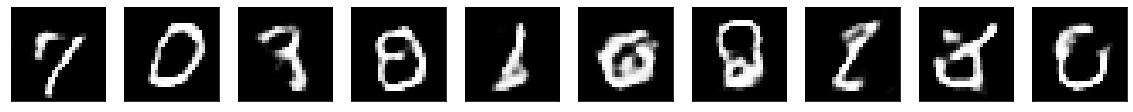

In [151]:
plt.figure(figsize=(2*n, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(generated_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## FINAL COMMENTS

As it can be seen, the training is like a fight between the discriminator and the generator: both of them are trying to minimize their loss, but in this way they are trying to increase the loss of the other component. It's like a MIn-Max game between two opponents.

In the end of this fight, the generator should win: it should be able to fool the discriminator.

**So, training a GAN is a particular process, which can be tricky. Training can be difficult.** THis is a drawback with respect to VAE.

But, on the contrary, GAN typically achieves better results. It reaches a better generation.